In [1]:
%load_ext autoreload
%autoreload 2

import jax.numpy as jnp
from jax import grad, jit, value_and_grad, make_jaxpr, config
from jax import random, profiler, config, debug, lax
from jax.nn import sigmoid
import numpy as np
import jax
import optax

from larndsim.sim_jax import load_data, prepare_tracks, simulate, simulate_parametrized, params_loss, id2pixel, get_pixel_coordinates, set_pixel_plane, chop_tracks
from larndsim.softdtw_jax import SoftDTW
from larndsim.consts_jax import build_params_class, load_detector_properties
from numpy.lib import recfunctions as rfn
from larndsim.quenching_jax import quench
from larndsim.drifting_jax import drift

import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py
jax.config.update('jax_platform_name', 'gpu')
config.update("jax_debug_nans", False)
from jax.experimental import checkify
plt.rcParams['font.size'] = 15
%config InlineBackend.figure_format = "retina"

In [5]:
#Loading the tracks

Params = build_params_class([])
ref_params = load_detector_properties(Params, "/home/pgranger/larnd-sim/jit_version/larnd-sim/larndsim/detector_properties/module0.yaml",
                                "/home/pgranger/larnd-sim/jit_version/larnd-sim/larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml")
# ref_params = ref_params.replace(kb=0.0486, tran_diff=0, long_diff=0, number_pix_neighbors=3, signal_length=300, electron_sampling_resolution=1e-3, vdrift=0.1596452482154287, lifetime=1e6, time_padding=190)
ref_params = ref_params.replace(kb=0.0486, tran_diff=0, long_diff=0, number_pix_neighbors=0, signal_length=191, electron_sampling_resolution=1e-3, vdrift=0.1596452482154287, lifetime=1e6, time_padding=190)
ref_params = ref_params.replace(time_window=ref_params.signal_length)
# ref_params = ref_params.replace(kb=0.0486, tran_diff=0, long_diff=0, number_pix_neighbors=5, signal_length=200, electron_sampling_resolution=1e-3)
# tracks_file = '/home/pgranger/larnd-sim/jit_version/larnd-sim/examples/module0_corsika.h5'
# tracks_file = '/home/pgranger/larnd-sim/jit_version/original/simplified_single_track.h5'
tracks_file = '/home/pgranger/larnd-sim/jit_version/larnd-sim/prepared_data/input_5.h5'
# tracks_file = '/home/pgranger/larnd-sim/jit_version/larnd-sim/single_track_drift.h5'
# tracks_file = "/home/pgranger/larnd-sim/jit_version/larnd-sim/prepared_data/selected_input_0.h5"
# tracks_file = '/home/pgranger/larnd-sim/jit_version/larnd-sim/debug/input_2_stripped.h5'
# tracks_file = '/home/pgranger/larnd-sim/jit_version/larnd-sim/single_edep.h5'
# tracks_file = '/home/pgranger/larnd-sim/jit_version/larnd-sim/double_edep.h5'
# tracks_file = '/home/pgranger/larnd-sim/jit_version/larnd-sim/single_track.h5'
# tracks_file = '/home/pgranger/larnd-sim/jit_version/larnd-sim/simplified_single_track_split.h5'
tracks, fields, original_tracks = prepare_tracks(ref_params, tracks_file)
# tracks = tracks[:100000]

response = np.load("/home/pgranger/larnd-sim/jit_version/original/build/lib/larndsim/bin/response_44.npy")
extended_response = np.zeros((50, 50, 1891))
extended_response[:45, :45, :] = response
response = extended_response
baseline = np.sum(response[:, :, :-ref_params.signal_length+1], axis=-1)
response = np.concatenate([baseline[..., None], response[..., -ref_params.signal_length+1:]], axis=-1)



# with jax.profiler.trace("/tmp/tensorboard"):
# ref, pixels_ref, ticks_ref, signals_ref, t0_ref, currents_idx, electrons, pix_renumbering, time_shift = simulate(ref_params, response, tracks, fields)
# ref, pixels_ref, ticks_ref, wfs = simulate(ref_params, response, tracks, fields)
ref, pixels_ref, ticks_ref, wfs = simulate_parametrized(ref_params, tracks, fields)

# plt.plot(signals_ref[:, :].T);
# plt.xlim(0, 100)

0.001


In [6]:
def toy_sim(params, tracks, fields):
     #Quenching and drifting
    new_tracks = quench(params, tracks, 2, fields)
    new_tracks = drift(params, new_tracks, fields)

    return new_tracks

    # #Simulating the electron generation according to the diffusion coefficients
    # electrons = generate_electrons(new_tracks, fields, rngkey)
    # #Getting the pixels where the electrons are
    # pIDs = get_pixels(params, electrons, fields)

    # n_neigh = params.number_pix_neighbors
    # npix = (2*n_neigh + 1)**2
    # main_pixels = pIDs[:, 2*n_neigh*(n_neigh+1)] #Getting the main pixel
    # pIDs = pIDs.ravel()

    # #Sorting the pixels and getting the unique ones
    # padded_size = pad_size(jnp.unique(main_pixels.ravel()).shape[0])
    # unique_pixels = jnp.sort(jnp.unique(main_pixels.ravel(), size=padded_size, fill_value=-1))

    # #Getting the renumbering of the pixels
    # npixels = unique_pixels.shape[0]
    # pix_renumbering = jnp.searchsorted(unique_pixels, pIDs)
    # #Only getting the electrons for which the pixels are in the active region
    # mask = (pix_renumbering < unique_pixels.size) & (unique_pixels[pix_renumbering] == pIDs)
    # pix_renumbering = pix_renumbering[mask]
    # elec_ids = jnp.nonzero(mask)[0]//npix #TODO: Optimize the cache size
    # electrons = electrons[elec_ids]

    # #Getting the pixel coordinates
    # xpitch, ypitch, plane, eid = id2pixel(params, unique_pixels[pix_renumbering])
    # pixels_coord = get_pixel_coordinates(params, xpitch, ypitch, plane)
    # #Getting the right indices for the currents
    # t0, currents_idx = current_lut(params, response, electrons, pixels_coord, fields)



    # nticks_wf = int(params.time_interval[1]/params.t_sampling) + 1 #Adding one first element to serve as a garbage collector
    # wfs = jnp.zeros((npixels, nticks_wf))

    # start_ticks = (t0/params.t_sampling + 0.5).astype(int) - params.time_window

    # # errors = checkify.user_checks | checkify.index_checks | checkify.float_checks
    # # checked_f = checkify.checkify(accumulate_signals, errors=errors)
    # # err, wfs = checked_f(wfs, currents_idx, electrons[:, fields.index("n_electrons")], response, pix_renumbering, start_ticks - earliest_tick, params.signal_length)
    # # err.throw()

    # wfs = accumulate_signals(wfs, currents_idx, electrons[:, fields.index("n_electrons")], response, pix_renumbering, start_ticks, params.signal_length)

    # integral, ticks = get_adc_values(params, wfs[:, 1:]*params.e_charge)

    # adcs = digitize(params, integral)
    # # return wfs, unique_pixels
    # return adcs, unique_pixels, ticks, wfs[:, 1:], t0, currents_idx, electrons, pix_renumbering, start_ticks

def toy_loss(params, tracks, ref, fields):
    new_tracks = toy_sim(params, tracks, fields)
    return jnp.sum((new_tracks[:, fields.index('n_electrons')] - ref[:, fields.index('n_electrons')])**2)

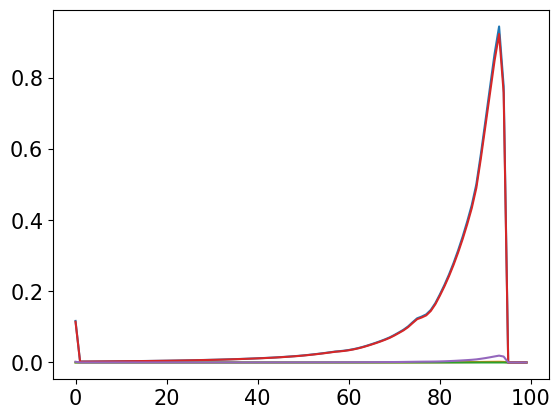

In [23]:
import jax
import jax.numpy as jnp

# Define the input
x, y = 1.8, 1.3  # Example continuous input coordinates

# Find the indices of the 4 neighbors
x0, x1 = jnp.floor(x).astype(int), jnp.ceil(x).astype(int)
y0, y1 = jnp.floor(y).astype(int), jnp.ceil(y).astype(int)

# Clip the indices to stay within the table bounds
x0 = jnp.maximum(x0, 0)
x1 = jnp.minimum(x1, response.shape[0] - 1)
y0 = jnp.maximum(y0, 0)
y1 = jnp.minimum(y1, response.shape[1] - 1)

# Get the neighboring pixel values
neighbors = jnp.array([
    response[x0, y0],  # Top-left
    response[x0, y1],  # Top-right
    response[x1, y0],  # Bottom-left
    response[x1, y1],  # Bottom-right
])

# Compute distances from input to each neighboring pixel
distances = jnp.array([
    -(x - x0)**2 - (y - y0)**2,  # Distance to top-left
    -(x - x0)**2 - (y - y1)**2,  # Distance to top-right
    -(x - x1)**2 - (y - y0)**2,  # Distance to bottom-left
    -(x - x1)**2 - (y - y1)**2,  # Distance to bottom-right
])

# Compute softmax weights based on distances
temperature = 0.1  # Adjust temperature for the softness
weights = jax.nn.softmax(distances / temperature)
# Compute the soft look-up result as a weighted sum of the neighbors
components = weights[:, None] * neighbors
soft_value = jnp.sum(components, axis=0)

plt.plot(soft_value)
plt.plot(components.T)

In [47]:
a = jnp.array([1, 2, 3, 4, 3, 3, 4, 2, 8, 1])
b = jnp.array([1, 2, 3])
unique_pixels, pix_renumbering = jnp.unique(b.ravel(),size=10, fill_value=-1, return_index=True)
pix_renumbering

Array([0, 1, 2, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [6]:
to_propagate = ("Ab", "kb", "lifetime", "tran_diff", "long_diff")
#Running some fit
Params = build_params_class(to_propagate)
ref_params = load_detector_properties(Params, "/home/pgranger/larnd-sim/jit_version/larnd-sim/larndsim/detector_properties/module0.yaml",
                                "/home/pgranger/larnd-sim/jit_version/larnd-sim/larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml")
# ref_params = ref_params.replace(Ab=0.8, kb=0.0486, tran_diff=4.0e-6, long_diff=1e-10, number_pix_neighbors=3, signal_length=100, electron_sampling_resolution=5e-3, vdrift=0.1596452482154287, lifetime=3e3, time_padding=190)
ref_params = ref_params.replace(Ab=0.8, kb=0.0486, tran_diff=4.0e-6, long_diff=8.8e-6, number_pix_neighbors=0, signal_length=100, electron_sampling_resolution=5e-3, vdrift=0.1596452482154287, lifetime=3e3, time_padding=190)
ref_params = ref_params.replace(time_window=ref_params.signal_length)

# tracks_file = '/home/pgranger/larnd-sim/jit_version/larnd-sim/single_track_drift.h5'
tracks_file = '/home/pgranger/larnd-sim/jit_version/larnd-sim/prepared_data/input_5.h5'
tracks, fields, original_tracks = prepare_tracks(ref_params, tracks_file)
# tracks = tracks[:100000]

response = np.load("/home/pgranger/larnd-sim/jit_version/original/build/lib/larndsim/bin/response_44.npy")
extended_response = np.zeros((50, 50, 1891))
extended_response[:45, :45, :] = response
response = extended_response
baseline = np.sum(response[:, :, :-ref_params.signal_length+1], axis=-1)
response = np.concatenate([baseline[..., None], response[..., -ref_params.signal_length+1:]], axis=-1)



# with jax.profiler.trace("/tmp/tensorboard"):
# ref, pixels_ref, ticks_ref  = simulate(ref_params, response, tracks, fields)
ref, pixels_ref, ticks_ref, wfs  = simulate_parametrized(ref_params, tracks, fields)

# ref = toy_sim(ref_params, tracks, fields)

# to_propagate = ("Ab", "kb", "lifetime")

history = []

niter = 1000

modified_params = {
    'Ab': 0.85,
    'kb': 0.0786,
    "lifetime": 5e3,
    "tran_diff": ref_params.tran_diff*1.3,
    "long_diff": ref_params.long_diff*0.7
    # "tran_diff": 6e-6
}

lr = {
    'Ab': 1e-2,
    'lifetime': 1e-2,
    'tran_diff': 1e-2,
    'long_diff': 1e-2,
    'kb': 1e-2
}

def extract_relevant_params(params, relevant):
    return {par: getattr(params, par) for par in relevant}

def update_params(params, update):
    return params.replace(**{key: getattr(params, key) + val for key, val in update.items()})

noisy_ref = ref# + jax.random.normal(jax.random.PRNGKey(87), ref.shape)*0.1

params = ref_params.replace(**modified_params)
# lr = 1e-2

params_normalization = params.replace()

norm_params = params.replace(**{key: 1. for key in to_propagate})

optimizer = optax.multi_transform({key: optax.adam(value) for key, value in lr.items()},
                                  {key: key for key in to_propagate})

opt_state = optimizer.init(extract_relevant_params(norm_params, to_propagate))

# optimizer = optax.adam(lr)
# opt_state = optimizer.init(norm_params)

# with jax.profiler.trace("/tmp/tensorboard"):
losses = []
gradd_list = []
# jax.profiler.start_trace("/tmp/tensorboard")
for i in tqdm(range(niter)):
    history.append(params)
    # for p in to_propagate:
    #     print(getattr(params, p))
    # value = params_loss(params, ref, pixels_ref, ticks_ref, tracks, fields)
    # print("Loss is:", value)
    # grads = grad(params_loss, (0))(params, ref, pixels_ref, ticks_ref, tracks, fields)
    # print(params)
        
    # (loss_val, aux), grads = value_and_grad(params_loss, (0), has_aux=True)(params, response, noisy_ref, pixels_ref, ticks_ref, tracks, fields)
    loss_val, aux = params_loss(params, noisy_ref, pixels_ref, ticks_ref, tracks, fields)
    grads, _ = grad(params_loss, (0), has_aux=True)(params, noisy_ref, pixels_ref, ticks_ref, tracks, fields)
    # (loss_val, aux), grads = value_and_grad(params_loss, (0), has_aux=True)(params, noisy_ref, pixels_ref, ticks_ref, tracks, fields)
        
    # loss_val, grads = value_and_grad(toy_loss, (0))(params, tracks, ref, fields)
    # print("Loss is:", loss_val)
    # print("Grad is:", grads.kb)
    # print(value)
    # print(grads.Ab, grads.kb, grads.lifetime)
    updates, opt_state = optimizer.update(extract_relevant_params(grads, to_propagate), opt_state)
    norm_params = update_params(norm_params, updates)
    # norm_params = optax.apply_updates(norm_params, updates)
    params = norm_params.replace(**{key: getattr(norm_params, key)*getattr(params_normalization, key) for key in to_propagate})
    losses.append(loss_val)
    gradd_list.append(grads)
    # max_radius = get_max_radius(params)
    # if max_radius != params.max_radius:
    #     params = params.replace(max_radius=max_radius)
    #     neighbors_sp = get_neighboring_pixels_sp(params, active_pixels_sp)
flat_history = {}
for key in to_propagate:
    flat_history[key] = [getattr(par, key) for par in history]
# jax.profiler.stop_trace()
#Compute the max radius at the beginning from all the tracks
#Eventually adapt it some parameters change by more than ...

0.005


100%|██████████| 1000/1000 [00:47<00:00, 20.96it/s]


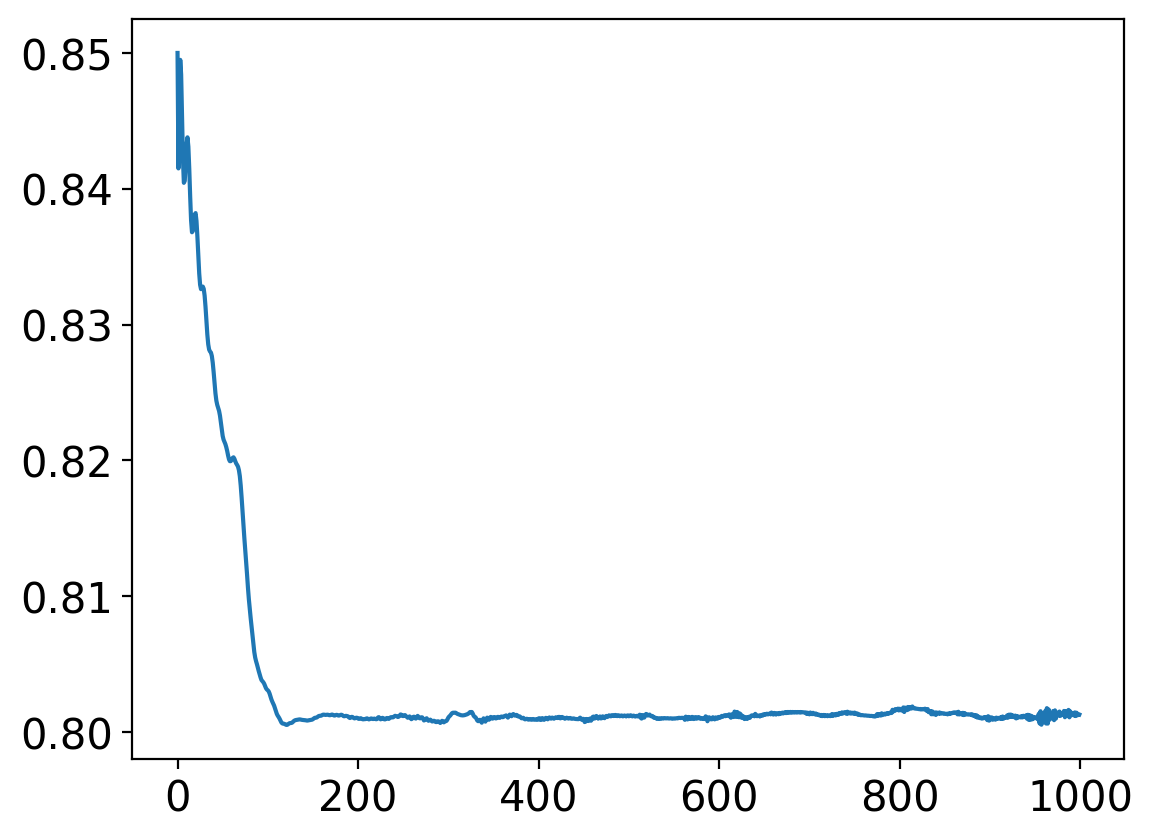

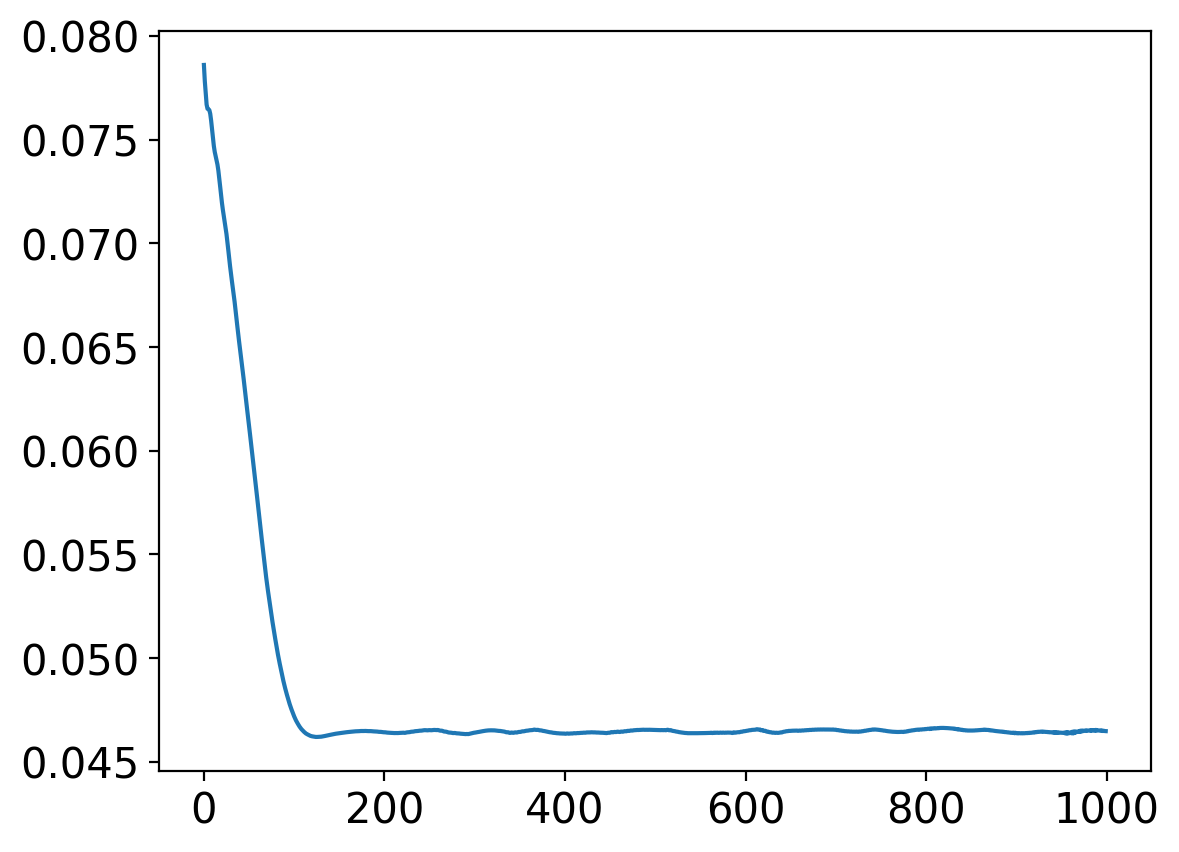

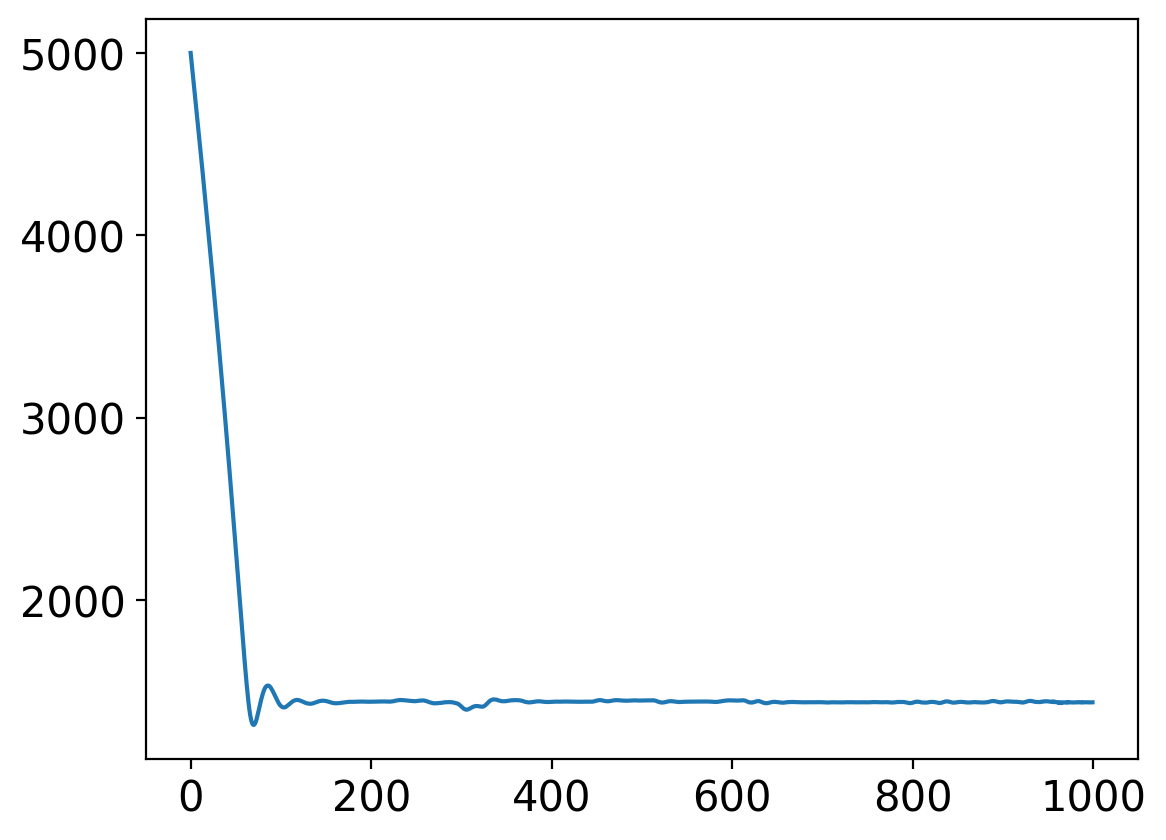

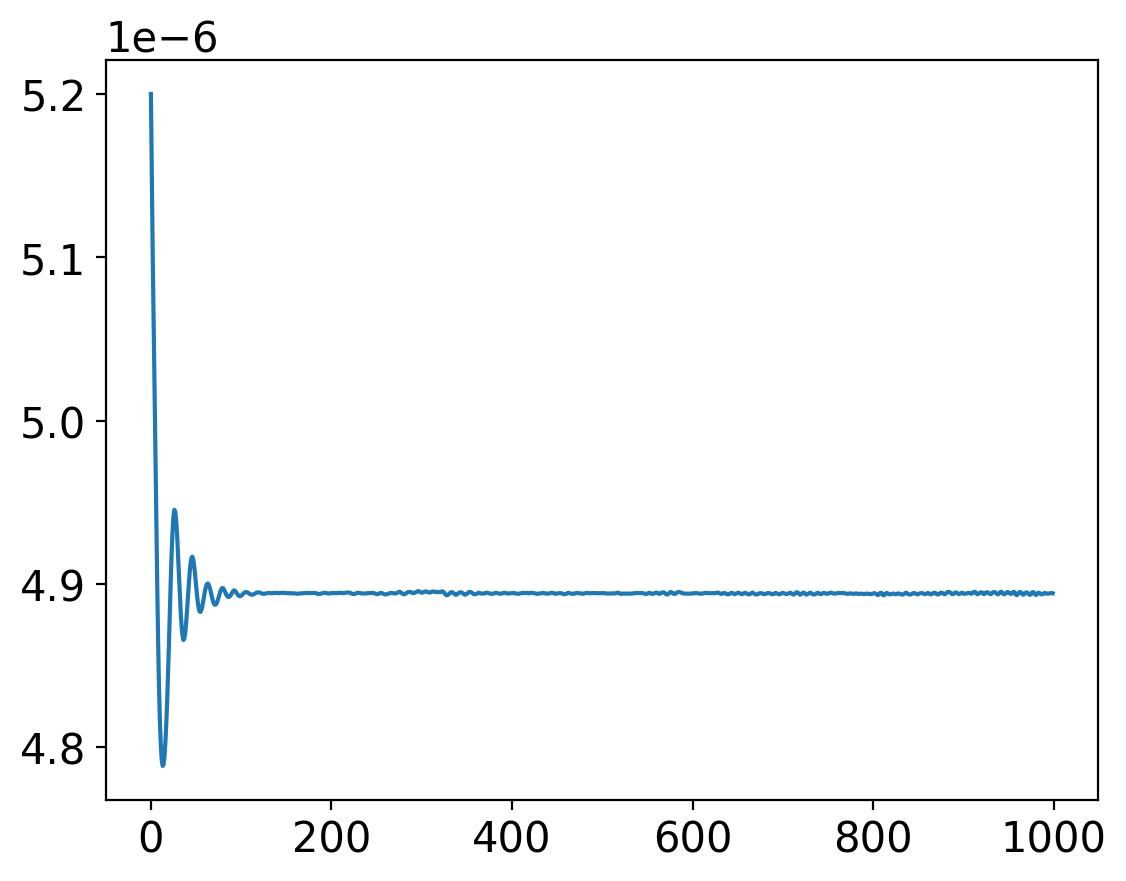

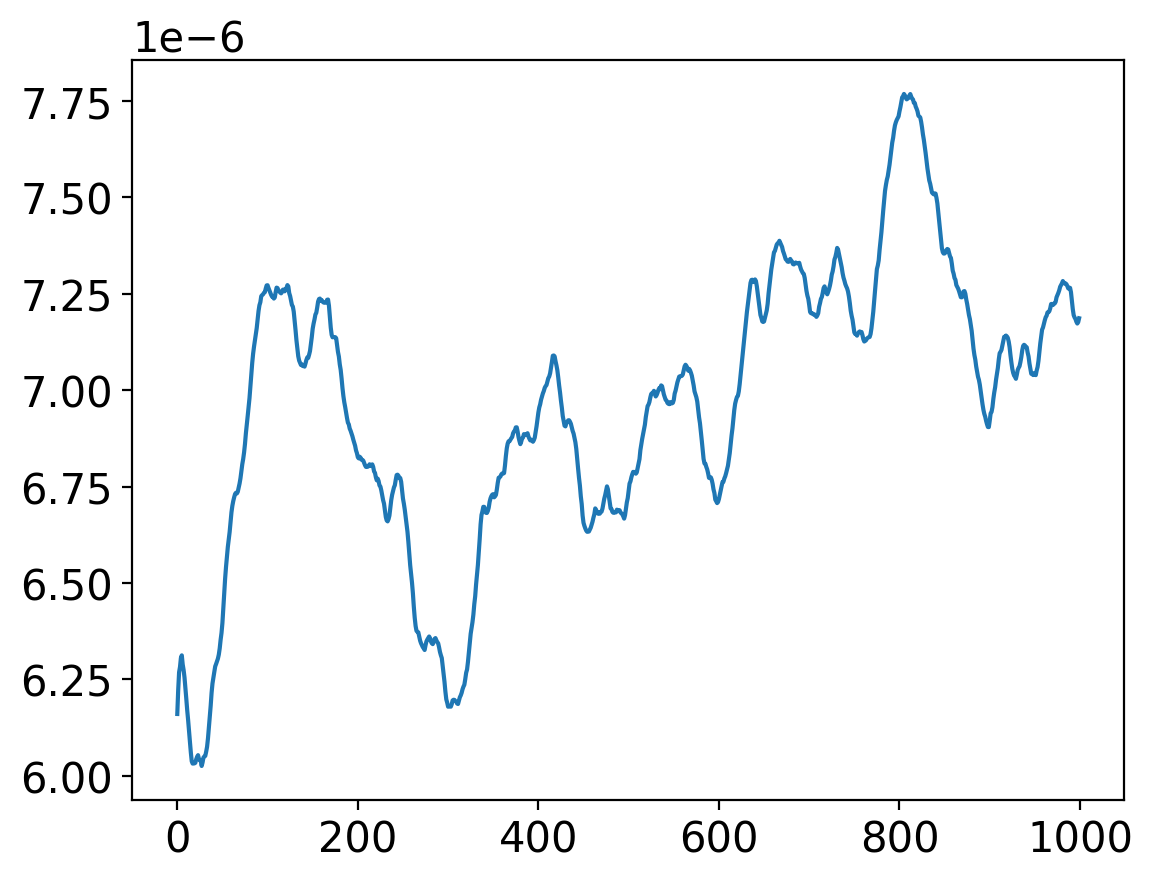

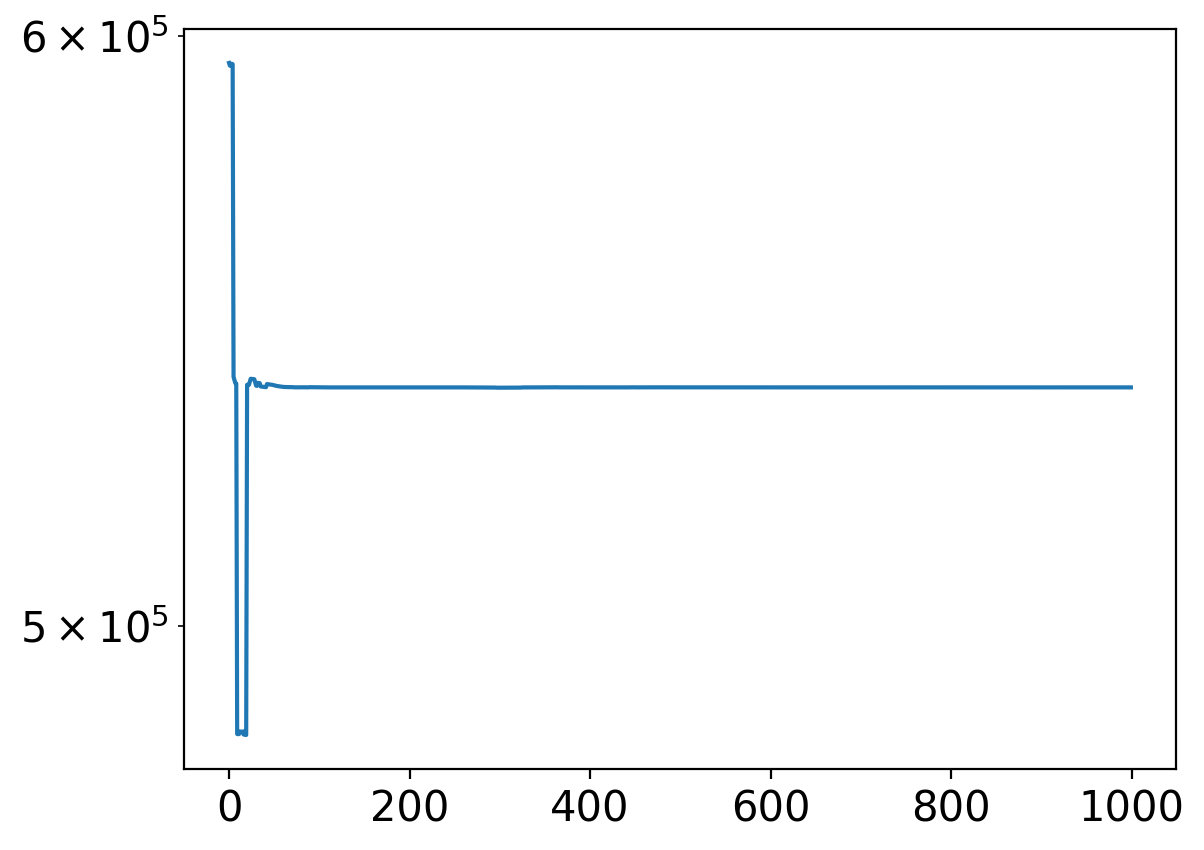

In [7]:
plt.plot(flat_history["Ab"])
plt.figure()
plt.plot(flat_history["kb"])
plt.figure()
plt.plot(flat_history["lifetime"])
plt.figure()
plt.plot(flat_history["tran_diff"])
plt.figure()
plt.plot(flat_history["long_diff"])
plt.figure()
plt.plot(losses)
plt.yscale("log")
# ax2.plot([grads.Ab for grads in gradd_list], color="red")

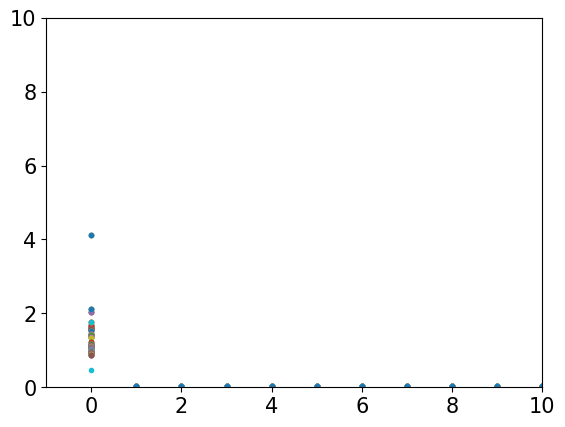

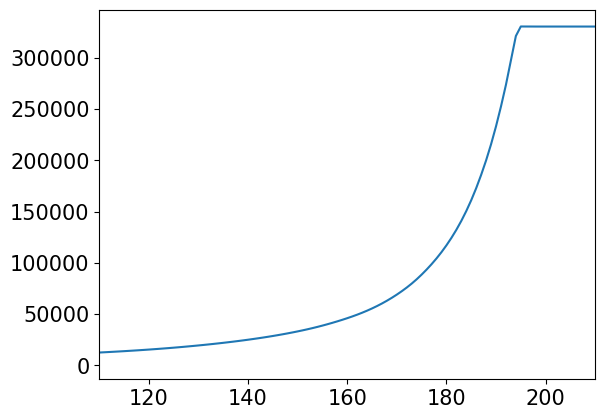

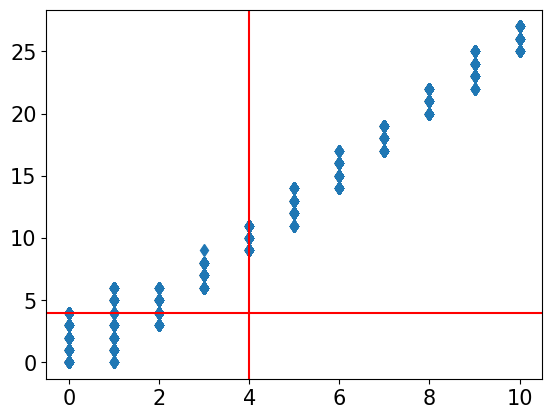

In [16]:
def get_elementary_wfs(pixid, unique_pixels, pix_renumbering, time_shift, currents_idx, nelectrons, response, params):
    pid_idx = np.where(unique_pixels == pixid)[0][0]
    signal_indices = np.where(pix_renumbering == pid_idx)[0]
    currents_idx = currents_idx[signal_indices]
    time_shift = time_shift[signal_indices]
    nelectrons = nelectrons[signal_indices]

    nticks_wf = int(params.time_interval[1]/params.t_sampling) + 1
    wfs = jnp.zeros((len(signal_indices), nticks_wf))
    start_indices = jnp.arange(len(signal_indices)) * nticks_wf + time_shift

    end_indices = start_indices[..., None] + jnp.arange(params.signal_length)
    flat_indices = jnp.ravel(end_indices)
    Nx, Ny, Nt = response.shape
    sig_indices = jnp.ravel((currents_idx[..., 0, None]*Ny + currents_idx[..., 1, None])*Nt + jnp.arange(response.shape[-1] - params.signal_length, response.shape[-1]))
    # print("signal_indices", signal_indices.shape)
    wfs = wfs.ravel()
    wfs = wfs.at[(flat_indices,)].set(response.take(sig_indices)*jnp.repeat(nelectrons, params.signal_length))
    return wfs.reshape((len(signal_indices), nticks_wf)), currents_idx

wfs, idxs = get_elementary_wfs(pixels_ref[21], pixels_ref, pix_renumbering, time_shift, currents_idx, nelectrons, response, ref_params)
plt.plot(wfs.T[:, ::10], linestyle='none', marker='.');
plt.xlim(-1, 10)
plt.ylim(0, 10)
plt.figure()
plt.plot(np.cumsum(np.sum(wfs, axis=0)))
plt.xlim(110, 210)
plt.figure()
plt.plot(idxs[:, 0], idxs[:, 1], 'd')
plt.axhline(4, color='r')
plt.axvline(4, color='r')

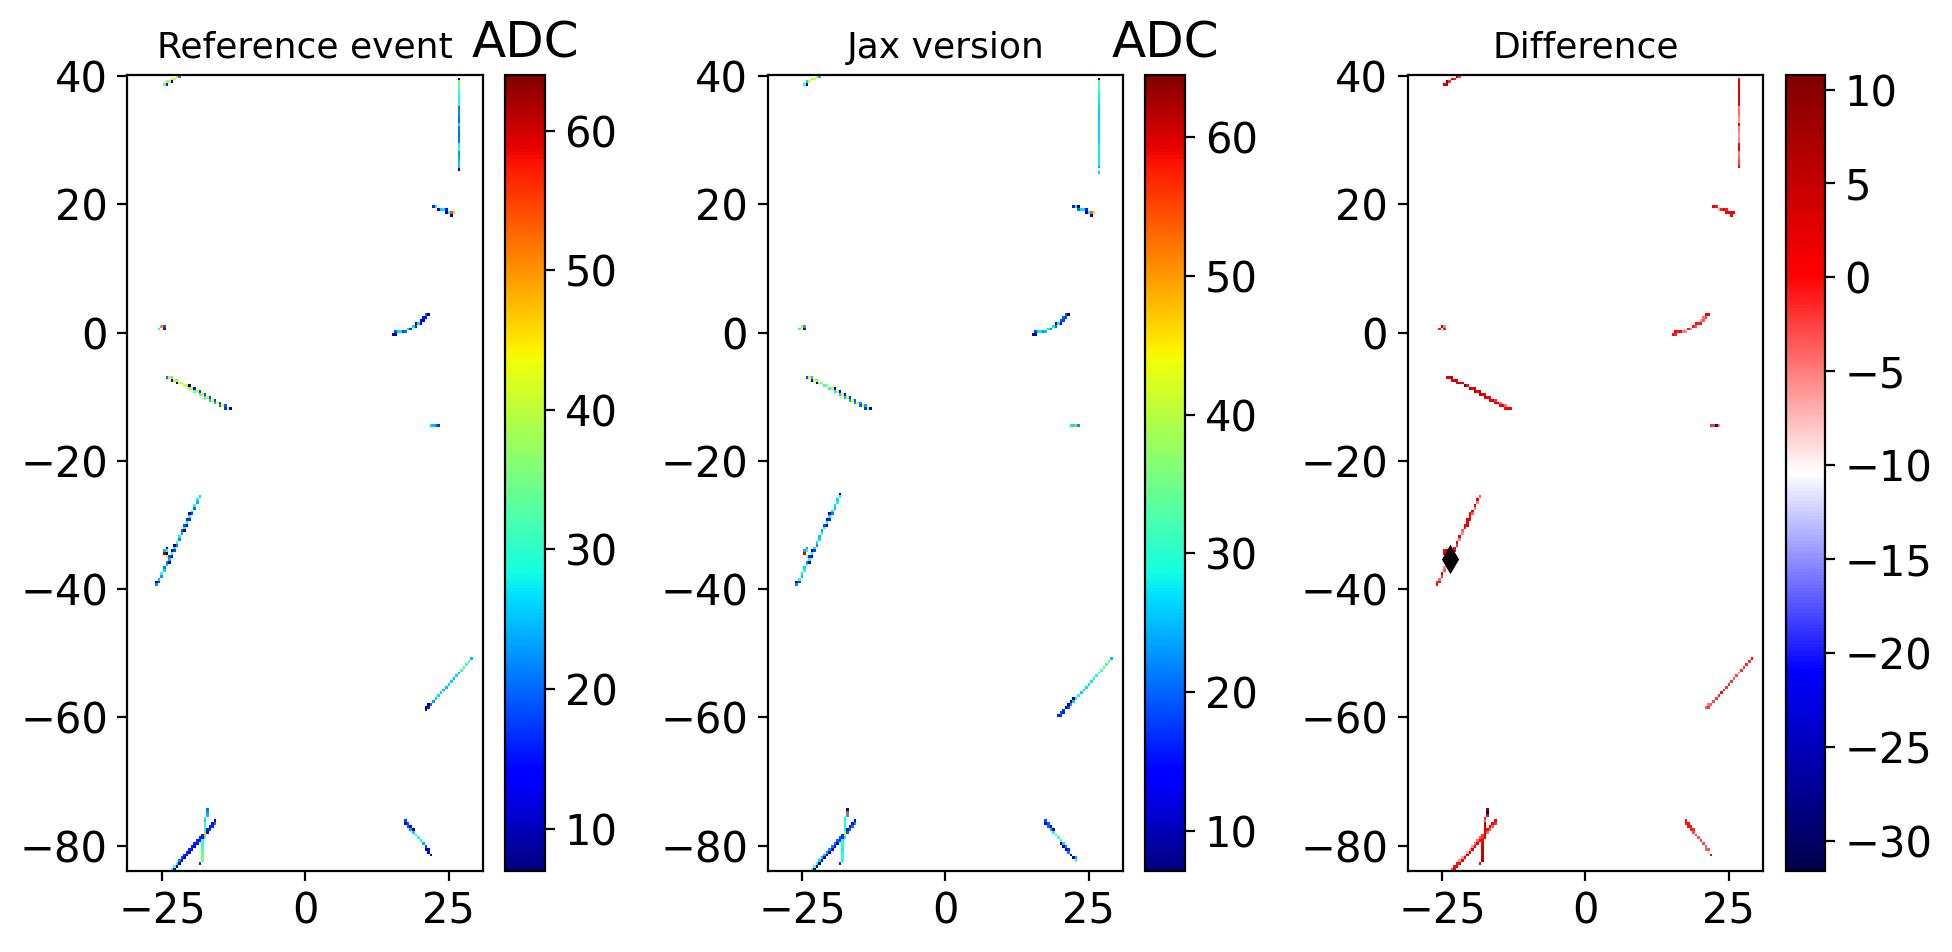

<Figure size 640x480 with 0 Axes>

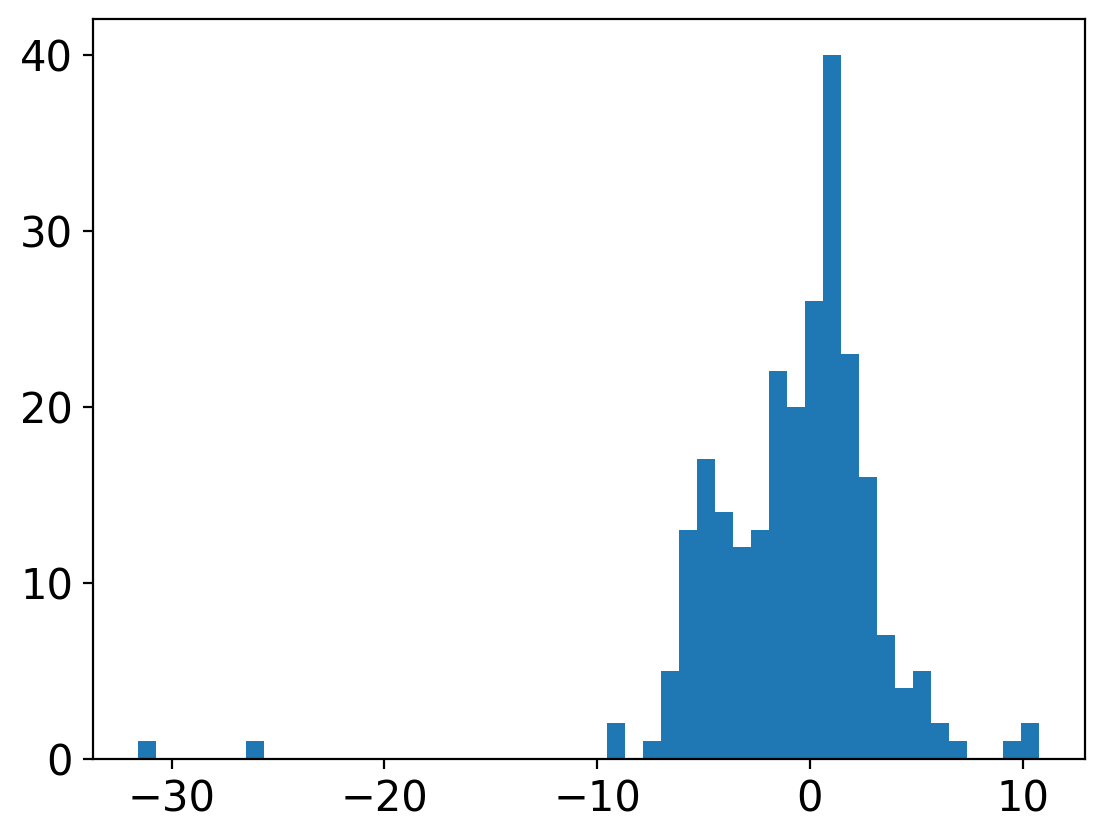

In [6]:
def load_results(fname):
    # fname = "/home/pgranger/larnd-sim/tools/evd/data/result_legacy_nonoise.h5"
    pixels = adc = signals = track_starts = pixel_index_map = track_pixel_map = pixel_signals = ticks = None
    with h5py.File(fname, 'r') as f:
        pixels = np.array(f['pixels'])
        adc = np.array(f['adc'])
        # signals = np.array(f['signals'])
        # track_starts = np.array(f['track_starts'])
        # pixel_index_map = np.array(f['pixel_index_map'])
        # track_pixel_map = np.array(f['track_pixel_map'])
        pixel_signals = np.array(f['pixel_signals'])
        ticks = np.array(f['ticks'])

    return pixels, signals, adc, ticks, pixel_signals, track_starts, pixel_index_map, track_pixel_map

# pixels, signals, adc, ticks, pixel_signals = load_results("/home/pgranger/larnd-sim/jit_version/original/simplified_single_track_output_lifetime.h5")
# pixels, signals, adc, ticks, pixel_signals = load_results("/home/pgranger/larnd-sim/jit_version/newest_output.h5")
pixels, signals, adc, ticks, pixel_signals, track_starts, pixel_index_map, track_pixel_map = load_results("/home/pgranger/larnd-sim/jit_version/output_5.h5")
# pixels_ref, signals_ref, ref, _, _, _, _, _ = load_results("/home/pgranger/larnd-sim/jit_version/output_wnoise_5.h5")
# pixels, signals, adc, ticks, pixel_signals, track_starts, pixel_index_map, track_pixel_map = load_results("/home/pgranger/larnd-sim/jit_version/output_single_track_drift.h5")
# pixels, signals, adc, ticks, pixel_signals = load_results("/home/pgranger/larnd-sim/jit_version/selected_output_0.h5")
# pixels, signals, adc, ticks, pixel_signals = load_results("/home/pgranger/larnd-sim/jit_version/original/single_edep_output_lifetime.h5")
# pixels, signals, adc, ticks, pixel_signals = load_results("/home/pgranger/larnd-sim/jit_version/original/double_edep_output_lifetime.h5")
# pixels, signals, adc, ticks = load_results("/home/pgranger/larnd-sim/jit_version/original/single_track_output_lifetime.h5")

fig, axs = plt.subplots(1, 3, figsize=(10, 5))


xpitch, ypitch, plane, eid = id2pixel(ref_params, pixels)
mask = plane == 0
coords = get_pixel_coordinates(ref_params, xpitch, ypitch, plane)
xbins = np.linspace(ref_params.tpc_borders[0][0][0] , ref_params.tpc_borders[0][0][1], ref_params.n_pixels_x + 1) 
ybins = np.linspace(ref_params.tpc_borders[0][1][0], ref_params.tpc_borders[0][1][1], ref_params.n_pixels_y + 1)
# xbins = np.linspace(-10, 10, int(np.ceil(20./ref_params.pixel_pitch)))
# ybins = np.linspace(0, 40, int(np.ceil(40./ref_params.pixel_pitch)))
# xbins = np.linspace(0, 7, int(np.ceil(7./ref_params.pixel_pitch)))
# ybins = np.linspace(30, 35, int(np.ceil(5./ref_params.pixel_pitch)))
# xbins = np.linspace(-30, -10, int(np.ceil(20./ref_params.pixel_pitch)))
# ybins = np.linspace(-90, -60, int(np.ceil(30./ref_params.pixel_pitch)))
h1, _, _, im = axs[0].hist2d(coords[mask, 0], coords[mask, 1], bins=(xbins, ybins), cmap='jet', weights=np.sum(adc[mask, :]-adc[0, 9], axis=1), cmin=1e-5);
# ax2.hist2d(coords[:, 0], coords[:, 1], bins=(xbins, ybins), cmap='jet', weights=np.sum(adc[:, :]-adc[0, 9], axis=1), cmin=1e-5);
# h1, _, _, im = axs[0].hist2d(coords[:, 0], coords[:, 1], bins=(xbins, ybins), cmap='jet');
# h1, _, _, im = axs[0].hist2d(coords[:, 0], coords[:, 1], bins=(xbins, ybins), cmap='jet', weights=adc[:, 0]-adc[0, 9], cmin=1e-5);
cbar = fig.colorbar(im, ax=axs[0])
cbar.ax.set_title("ADC")

xpitch, ypitch, plane, eid = id2pixel(ref_params, pixels_ref)
mask = plane == 0
coords = get_pixel_coordinates(ref_params, xpitch, ypitch, plane)
# h2, _, _, im = axs[1].hist2d(coords[pixels_ref != -1][:, 0], coords[pixels_ref != -1][:, 1], bins=(xbins, ybins), cmap='jet');
# h2, _, _, im = axs[1].hist2d(coords[:, 0], coords[:, 1], bins=(xbins, ybins), cmap='jet', weights=ref[:, 0]-ref[0, 9], cmin=1e-5);
h2, _, _, im = axs[1].hist2d(coords[mask, 0], coords[mask, 1], bins=(xbins, ybins), cmap='jet', weights=np.sum(ref[mask, :]-ref[0, 9], axis=1), cmin=1e-5);
# ax3.hist2d(coords[:, 0], coords[:, 1], bins=(xbins, ybins), cmap='jet', weights=np.sum(ref[:, :]-ref[0, 9], axis=1), cmin=1e-5);
cbar = fig.colorbar(im, ax=axs[1])
# axs[1].scatter(coords[:, 0], coords[:, 1], marker='d', color='k')
# axs[0].scatter(coords[:, 0], coords[:, 1], marker='d', color='k')
cbar.ax.set_title("ADC")
axs[0].set_title("Reference event", fontsize=13)
axs[1].set_title("Jax version", fontsize=13)
# fig.tight_layout()
# fig.savefig("evd_diff.pdf")
# coords = get_pixel_coordinates(ref_params, pixels[:, 0], pixels[:, 1], np.zeros(adcs.shape[0]))


xpitch, ypitch, plane, eid = id2pixel(ref_params, np.array([15276]))
coords = get_pixel_coordinates(ref_params, xpitch, ypitch, plane)
axs[2].plot(coords[0, 0], coords[0, 1], 'd', color='k')


im = axs[2].pcolormesh(xbins, ybins, h1.T - h2.T, cmap='seismic')
cbar = fig.colorbar(im, ax=axs[2])
axs[2].set_title("Difference", fontsize=13)
fig.tight_layout()

# for i in range(3):
#     axs[i].set_xlim(-10, 10)
#     axs[i].set_ylim(0, 40)
    # axs[i].set_xlim(-4, -3)
    # axs[i].set_ylim(9, 12)

# xstart = original_tracks[0, fields.index('x_start')]
# ystart = original_tracks[0, fields.index('y_start')]
# xend = original_tracks[0, fields.index('x_end')]
# yend = original_tracks[0, fields.index('y_end')]

# axs[0].plot([xstart, xend], [ystart, yend], color='k')
# axs[1].plot([xstart, xend], [ystart, yend], color='k')
plt.figure()
with h5py.File(f"/home/pgranger/larnd-sim/jit_version/larnd-sim/prepared_data/input_0.h5", 'r') as f:
# with h5py.File(f'/home/pgranger/larnd-sim/jit_version/larnd-sim/single_track_drift.h5', 'r') as f:
    original_tracks = np.array(f['segments'])
for i in range(len(original_tracks)):
    xstart = original_tracks[i]['z_start']
    ystart = original_tracks[i]['y_start']
    xend = original_tracks[i]['z_end']
    yend = original_tracks[i]['y_end']
    # axs[1].plot([xstart, xend], [ystart, yend], 'r')
    # plt.text(xend + 0.5, yend + 0.5, f"{i}", color='r', fontsize=8)

def pretty_print(track):
    print("================================")
    for key in track.dtype.names:
        print(f"{key}: {track[key]}")

# pretty_print(original_tracks[87])
# pretty_print(original_tracks[20])

# plt.colorbar()
plt.figure()
plt.hist((h1 - h2).flatten(), bins=50);
# axs[0].set_ylim(-40, -32.5)
# axs[1].set_ylim(-40, -32.5)
# axs[2].set_ylim(-40, -32.5)
# axs[0].set_xlim(-30, -20)
# axs[1].set_xlim(-30, -20)
# axs[2].set_xlim(-30, -20)

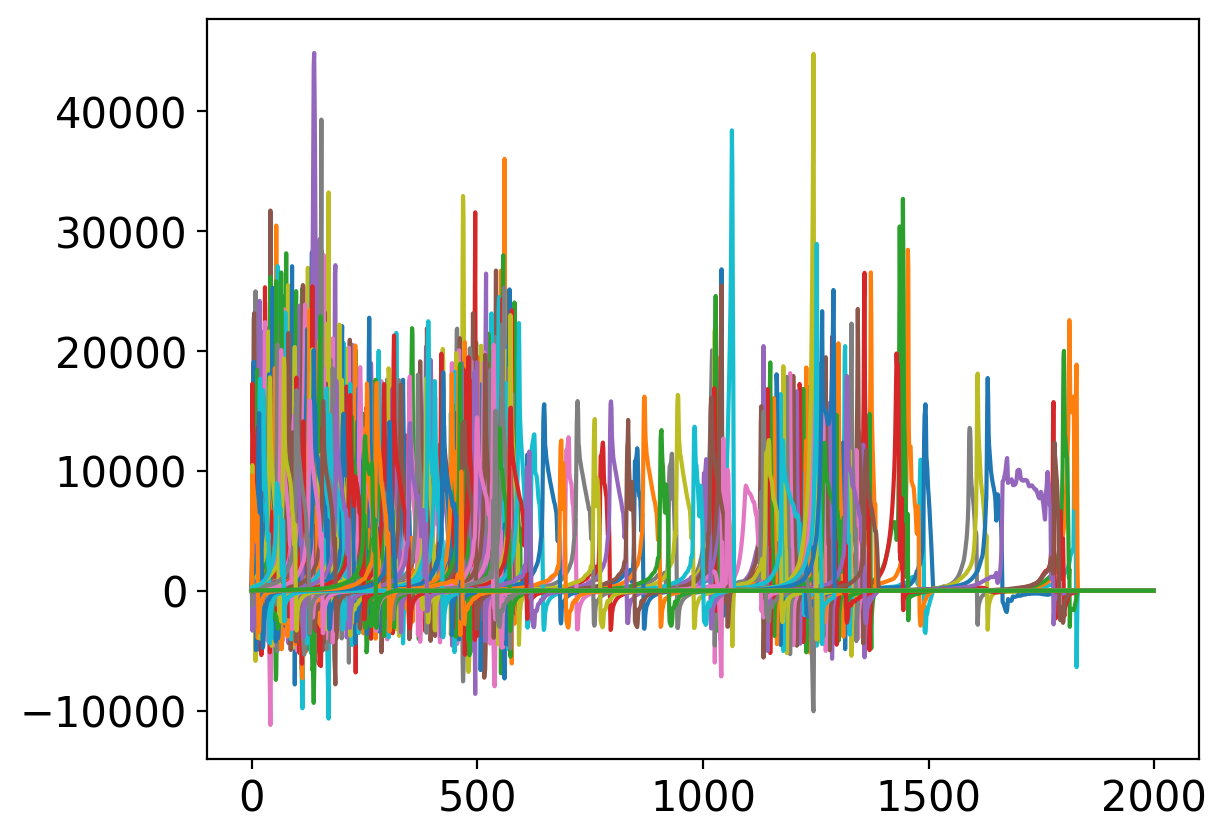

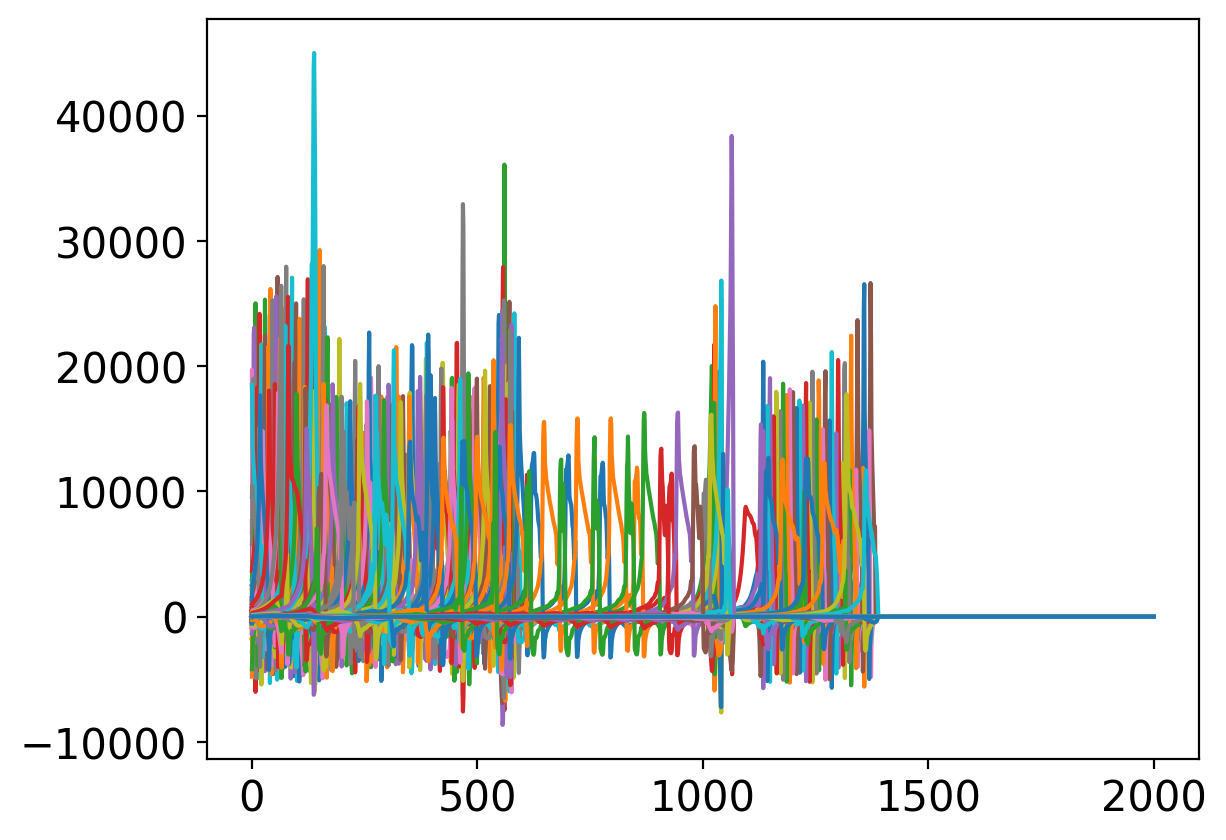

In [4]:
# plt.plot(wfs.T[:, :]/ref_params.e_charge);
plt.plot(wfs.T[:, :]);
plt.figure()
plt.plot(pixel_signals.T[:, :]);

In [5]:
#Is there any difference in the activated pixels?
xpitch, ypitch, plane, eid = id2pixel(ref_params, pixels)
mask = plane == 0
xpitch, ypitch, plane, eid = id2pixel(ref_params, pixels_ref)
mask_ref = plane == 0


activated_pixels = pixels[mask & (np.sum(adc - adc[0, -1], axis=1) > 0)]
activated_pixels_ref = pixels_ref[mask_ref & (np.sum(ref - ref[0, -1], axis=1) > 0)]

#Getting rid of the event id for ref
activated_pixels_ref = activated_pixels_ref % (ref_params.n_pixels_x*ref_params.n_pixels_y*ref_params.tpc_borders.shape[0])

print("There are {} activated pixels in the original version".format(activated_pixels.shape[0]))
print("There are {} activated pixels in the jax version".format(activated_pixels_ref.shape[0]))
print("The pixels are the same:", sorted(activated_pixels) == sorted(activated_pixels_ref))
if sorted(activated_pixels) != sorted(activated_pixels_ref):
    print("The difference is:", set(activated_pixels.tolist()) - set(activated_pixels_ref.tolist()))
    print("The difference is:", set(activated_pixels_ref.tolist()) - set(activated_pixels.tolist()))

There are 257 activated pixels in the original version
There are 75 activated pixels in the jax version
The pixels are the same: False
The difference is: {27136, 14854, 9226, 16400, 18, 2071, 2072, 38937, 38938, 17946, 1568, 1569, 1570, 34850, 24097, 24099, 36390, 37930, 8238, 8239, 15415, 15416, 15417, 16962, 16963, 581, 582, 32327, 1097, 1098, 35410, 2132, 2133, 36950, 26711, 23132, 23134, 14433, 8803, 15978, 15979, 37370, 17524, 17525, 1145, 1146, 35970, 2691, 26754, 37510, 23686, 39050, 27276, 27277, 9367, 159, 2210, 2211, 39080, 24235, 1709, 1710, 34990, 24237, 36530, 14011, 8380, 22718, 22720, 15555, 32465, 722, 723, 1237, 2273, 2274, 37090, 26852, 26853, 23270, 23272, 8944, 16119, 38654, 38655, 10495, 17665, 1286, 1287, 34570, 36110, 2831, 23823, 23824, 37650, 7957, 27417, 27418, 15135, 15136, 16681, 16682, 300, 2349, 2350, 18227, 819, 308, 26424, 26425, 1850, 1851, 35130, 36670, 14151, 14152, 22856, 22858, 15694, 15697, 15698, 32602, 17243, 17244, 32603, 32604, 863, 1376, 864, 

In [9]:
pixels_ref.shape

(500,)

In [30]:
# Looking at the waveforms

first_adcs = adc[:, 0]
# print(first_adcs - 74)

pixel0 = 1


# pixel0 = np.argwhere(first_adcs - 74 == 7)[0][0]

pixid = pixels[pixel0]

pixel1 = np.argwhere(pixels_ref % (ref_params.n_pixels[0] * ref_params.n_pixels[1]*ref_params.tpc_borders.shape[0]) == pixid)[0][0]
print("Adc in jax ->", ref[pixel1, 0])
# if ref[pixel1, 0] > 75:
# print("Idx ->", idx)
print("Ticks in ref ->", ticks[pixel0])
print("Adc in ref ->", first_adcs[pixel0])
print("Ticks in jax ->", ticks_ref[pixel1])
print("Adc in jax ->", ref[pixel1, 0])


length = pixel_signals.shape[1]
length_ref = signals_ref.shape[1]
# print(ref[pixel1, 1] - ref[pixel1, -1])
plt.figure()
# plt.plot(np.arange(length), pixel_signals[pixel0, :])
# plt.plot(np.arange(length), np.cumsum(pixel_signals[pixel0, :]))
plt.plot(np.arange(len(pixel_signals[pixel0, 0:])) + 0, np.cumsum(pixel_signals[pixel0, 0:]), label="ref")
# plt.plot(np.arange(length_ref) + 854 + 200, signals_ref[pixel1, :])
# plt.plot(np.arange(length_ref) + 854, np.cumsum(signals_ref[pixel1, :]))
plt.plot(np.arange(length_ref) + 1054, signals_ref[pixel1, :], label="jax")
plt.xlim(1000, 1300)
# plt.ylim(0, 200)
plt.title("Cumulative signals on a pixel")
plt.xlabel("Time ticks")

IndexError: index 0 is out of bounds for axis 0 with size 0

There are 257 activated pixels in the original version
There are 78 activated pixels in the jax version
The pixels are the same: False
The difference is: {27136, 14854, 9226, 16400, 18, 2071, 2072, 38937, 38938, 17946, 1568, 1569, 1570, 34850, 24097, 24099, 36390, 37930, 8238, 8239, 15415, 15416, 15417, 16962, 16963, 581, 582, 32327, 1097, 1098, 35410, 2132, 2133, 36950, 26711, 23132, 23134, 14433, 8803, 15978, 15979, 37370, 17524, 17525, 1145, 1146, 35970, 2691, 26754, 37510, 23686, 39050, 27276, 27277, 9367, 159, 2210, 2211, 39080, 24235, 1709, 1710, 34990, 24237, 36530, 14011, 8380, 22718, 22720, 15555, 32465, 722, 723, 1237, 2273, 2274, 37090, 26852, 26853, 23270, 23272, 8944, 16119, 38654, 38655, 10495, 17665, 1286, 1287, 34570, 36110, 2831, 23823, 23824, 37650, 7957, 27417, 27418, 15135, 15136, 16681, 16682, 300, 2349, 2350, 18227, 819, 308, 26424, 26425, 1850, 1851, 35130, 36670, 14151, 14152, 22856, 22858, 15694, 15697, 15698, 32602, 17243, 17244, 32603, 32604, 863, 1376, 864, 

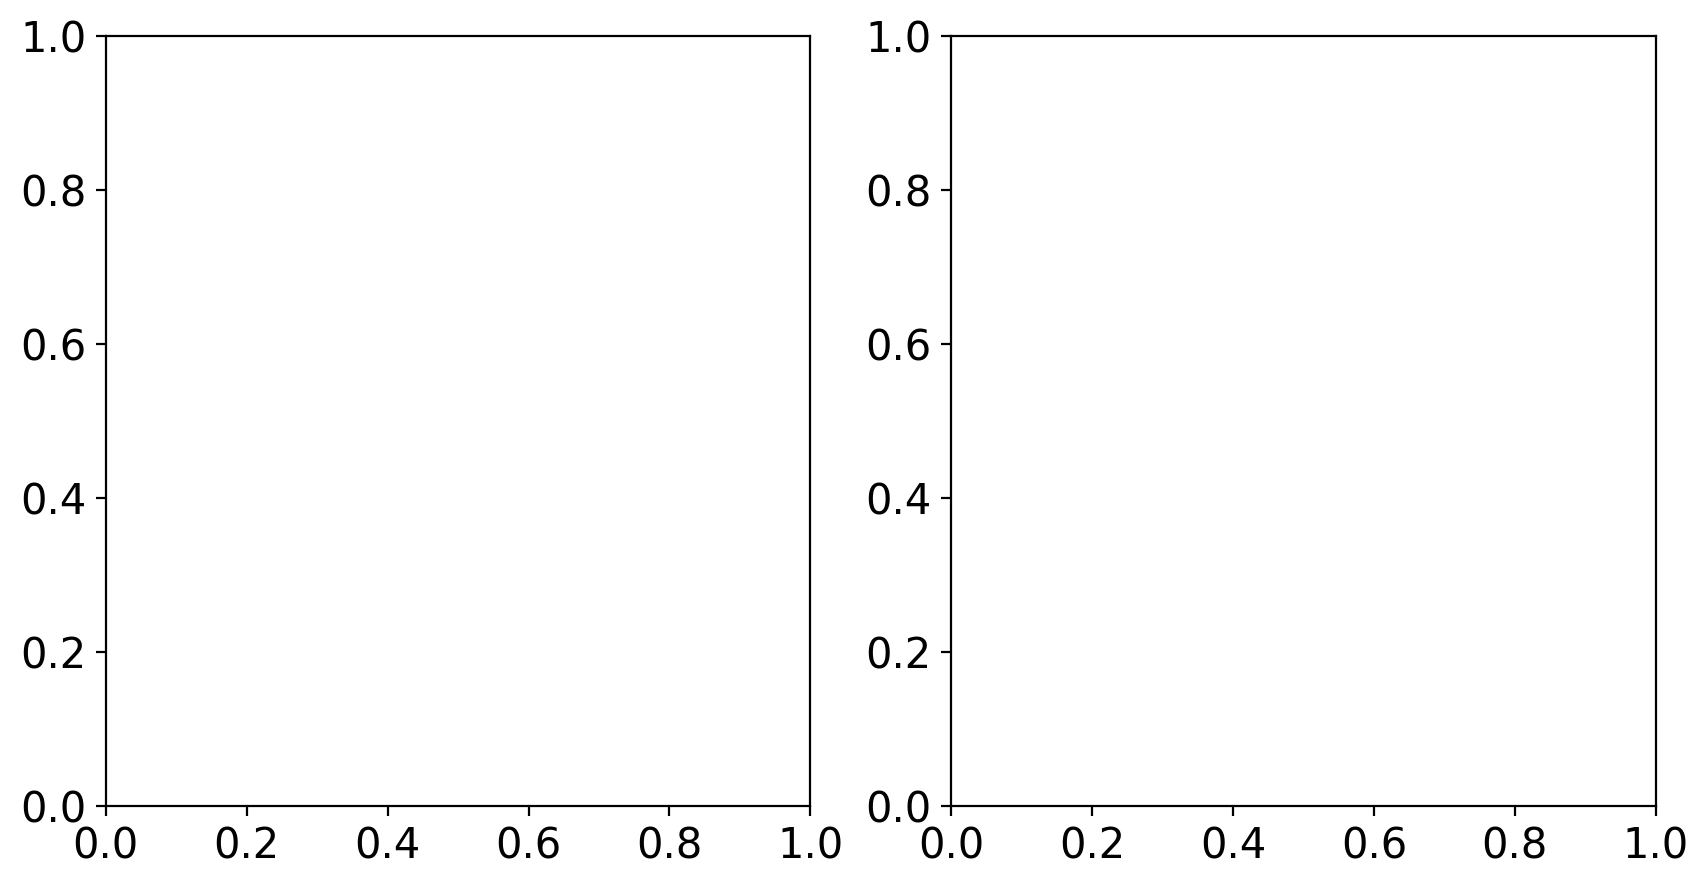

In [6]:
#Is there any difference in the activated pixels?
xpitch, ypitch, plane, eid = id2pixel(ref_params, pixels)
mask = plane == 0
xpitch, ypitch, plane, eid = id2pixel(ref_params, pixels_ref)
mask_ref = plane == 0

signals_ref = wfs

activated_pixels = pixels[mask & (np.sum(adc - adc[0, -1], axis=1) > 0)]
activated_pixels_ref = pixels_ref[mask_ref & (np.sum(ref - ref[0, -1], axis=1) > 0)]

#Getting rid of the event id for ref
activated_pixels_ref = activated_pixels_ref % (ref_params.n_pixels_x*ref_params.n_pixels_y*ref_params.tpc_borders.shape[0])

print("There are {} activated pixels in the original version".format(activated_pixels.shape[0]))
print("There are {} activated pixels in the jax version".format(activated_pixels_ref.shape[0]))
print("The pixels are the same:", sorted(activated_pixels) == sorted(activated_pixels_ref))
if sorted(activated_pixels) != sorted(activated_pixels_ref):
    print("The difference is:", set(activated_pixels.tolist()) - set(activated_pixels_ref.tolist()))
    print("The difference is:", set(activated_pixels_ref.tolist()) - set(activated_pixels.tolist()))

length = 1980
ticks_offset = 1054 - ref_params.signal_length//2 + 50
ticks_offset = 0
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
count = -1
selector = 0
for pixel0 in range(len(activated_pixels)):
    
    pixid = activated_pixels[pixel0]
    # pixid = 37320
    print(pixid)
    try:
        pixel1 = np.argwhere(pixels_ref % (ref_params.n_pixels_x * ref_params.n_pixels_y*ref_params.tpc_borders.shape[0]) == pixid)[0][0]
        pixel0 = np.argwhere(pixels == pixid)[0][0]
    except:
        continue

    diff_adc = np.sum(adc[pixel0, :] - adc[pixel0, -1]) - np.sum(ref[pixel1, :] -ref[pixel1, -1])
    print("Diff adc:", diff_adc)
    if abs(diff_adc) < 70:
        continue
    count += 1
    if count != selector:
        continue
    print(adc[pixel0, :])
    print(ref[pixel1, :])
    signal_original = np.pad(np.cumsum(pixel_signals[pixel0, :]), (2000, 2000))[2000+ticks_offset:2000+ticks_offset+length]
    signal_jax = np.cumsum(signals_ref[pixel1, :length])/ref_params.e_charge
    # signal_original = np.pad(pixel_signals[pixel0, :], (2000, 2000))[2000+ticks_offset:2000+ticks_offset+length]
    # signal_jax = signals_ref[pixel1, :length]/ref_params.e_charge

    axs[0].plot(signal_original, label="Original")
    axs[0].plot(signal_jax, label="Jax")
    axs[1].plot(signal_original - signal_jax, label="Difference")
    axs[0].legend()
    print("Pixel index: ", pixel1)
    print("Pixel id", pixels_ref[pixel1])
    print("Pixel index: ", pixel0)
    print("Pixel id", pixels[pixel0])
    break
# print(len(signal_original))
# print(len(signal_jax))
# integral, ticks = get_adc_values(ref_params, signal_original[None, :]*ref_params.e_charge)
# print("Jax digitizer, original signal:", digitize(ref_params, integral))
# integral, ticks = get_adc_values(ref_params, signal_jax[None, :]*ref_params.e_charge)
# print("Jax digitizer, jax signal:", digitize(ref_params, integral))
# time_ticks =np.linspace(0, ref_params.time_interval[1], pixel_signals.shape[1]+1)
# integral_list = np.zeros((1, 10))
# adc_ticks_list = np.zeros((1, 10))

# get_adc_values_ref(np.insert(np.diff(signal_original), 0, signal_original[0])[None, :]*ref_params.e_charge, time_ticks, integral_list, adc_ticks_list)
# print("Original digitizer, original signal:",digitize(ref_params, integral_list))

# time_ticks =np.linspace(0, ref_params.time_interval[1], pixel_signals.shape[1]+1)
# integral_list = np.zeros((1, 10))
# adc_ticks_list = np.zeros((1, 10))
# get_adc_values_ref(np.insert(np.diff(signal_jax), 0, signal_jax[0])[None, :]*ref_params.e_charge, time_ticks, integral_list, adc_ticks_list)
# print("Original digitizer, jax signal:", digitize(ref_params, integral_list))
# axs[0].set_xlim(1500, 2000)
# axs[1].set_xlim(1500, 2000)
# axs[1].set_ylim(-10000, 10000)
# axs[0].set_ylim(200000, 250000)

In [15]:
activated_pixels

array([28058, 28198, 28199, 28339, 28479, 28619, 28620, 28760, 28900,
       29040, 29041, 29181, 29321, 29461, 29462, 29602, 29742, 29882,
       29883, 30023, 30163, 30303, 30304, 30444, 30584, 30724, 30725,
       30865, 31005, 31145, 31146, 31286, 31426, 31566, 31567, 31707,
       31847, 31987, 31988, 32128, 32268, 32408, 32409, 32549, 32689,
       32829, 32830, 32970, 33110, 33250, 33251, 33391, 33531, 33671,
       33672, 33812, 33952, 34092, 34093, 34233, 34373, 34513, 34514,
       34654, 34794, 34934, 34935, 35075, 35215, 35355, 35356, 35496,
       35636, 35776, 35777, 35917, 36057, 36197, 36198, 36338, 36478,
       36618, 36619, 36759, 36899, 37039, 37040, 37180, 37320, 37460,
       37461], dtype=int32)

(94, 1892)


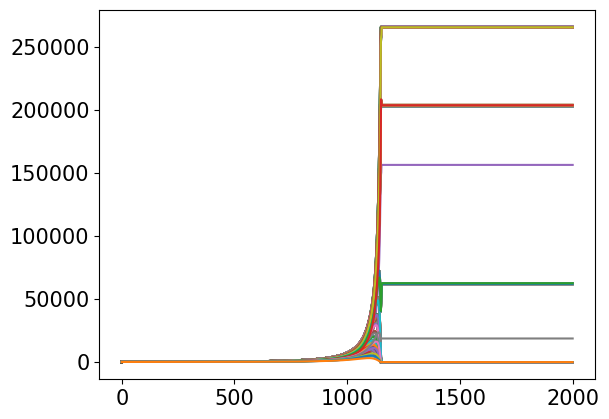

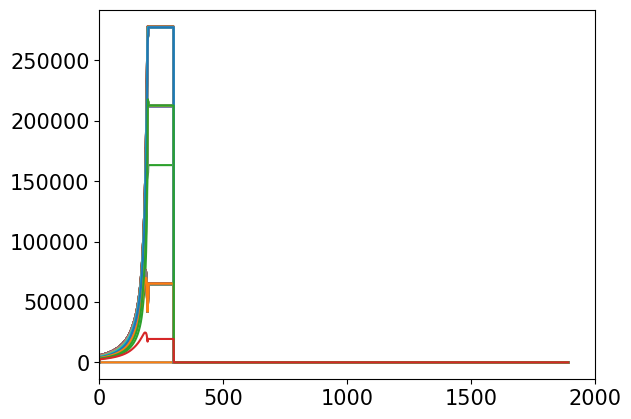

In [9]:
plt.plot(np.cumsum(pixel_signals, axis=1).T)
plt.figure()
plt.plot(signals_ref.T);
plt.xlim(0, 2000)
print(signals_ref.shape)

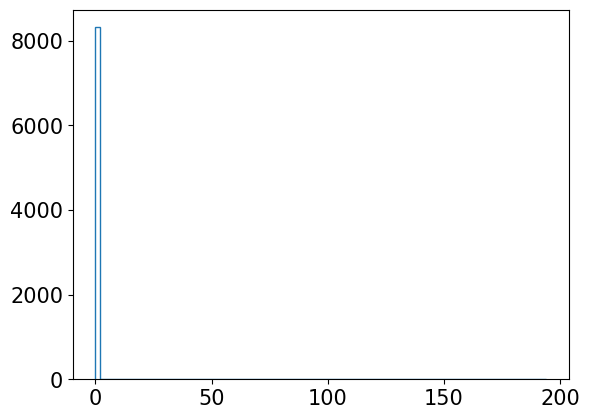

In [41]:
# plt.hist(t0_ref, bins=100, histtype='step');
plt.hist(ticks.flatten(), bins=100, histtype='step');

In [10]:
ticks

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [181]:
from functools import partial

@partial(jit, static_argnames='signal_length')
def accumulate_signals(wfs, currents_idx, charge, response, pixID, start_ticks, signal_length):
    # Get the number of pixels and ticks
    Npixels, Nticks = wfs.shape

    # Compute indices for updating wfs, taking into account start_ticks
    start_indices = pixID * Nticks + start_ticks[:, jnp.newaxis] 

    end_indices = start_indices[..., None] + jnp.arange(signal_length)

    # Flatten the indices
    flat_indices = jnp.ravel(end_indices)
    # print("flat_indices", flat_indices.shape)
    # print("start_indices", start_indices.shape)
    # print("end_indices", end_indices.shape)

    Nx, Ny, Nt = response.shape

    signal_indices = jnp.ravel((currents_idx[..., 0, None]*Ny + currents_idx[..., 1, None])*Nt + jnp.arange(response.shape[-1] - signal_length, response.shape[-1]))
    # print("signal_indices", signal_indices.shape)

    Np = pixID.shape[-1]

    # Update wfs with accumulated signals
    wfs = wfs.ravel()
    wfs = wfs.at[(flat_indices,)].add(response.take(signal_indices)*jnp.repeat(charge, Np*signal_length))
    return wfs.reshape((Npixels, Nticks))

current0 = np.linspace(0, 1000, 1000)
current1 = np.linspace(0, 3000, 1000)

response = np.stack([current0, current1], axis=0)
response.shape

(2, 1000)

In [156]:
plt.hist(reponse)

(1, 282, 1912)
(282, 2001)


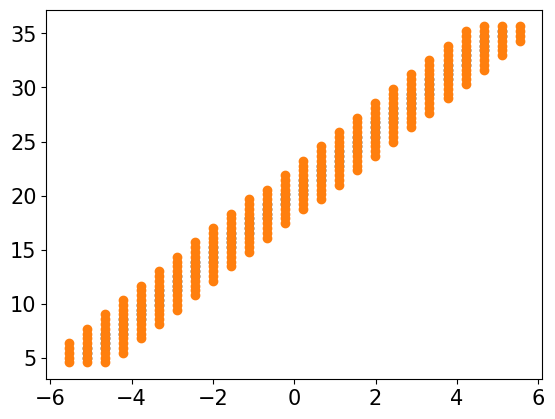

In [30]:
pixels, signals, adc, ticks, pixel_signals = load_results("/home/pgranger/larnd-sim/jit_version/original/simplified_single_track_output_lifetime.h5")
xpitch, ypitch, plane, eid = id2pixel(ref_params, pixels)
coords = get_pixel_coordinates(ref_params, xpitch, ypitch, np.zeros(pixels.shape[0]))
plt.scatter(*zip(*coords))

pixels, signals, adc, ticks, pixel_signals = load_results("/home/pgranger/larnd-sim/jit_version/newest_output.h5")
xpitch, ypitch, plane, eid = id2pixel(ref_params, pixels)
coords = get_pixel_coordinates(ref_params, xpitch, ypitch, np.zeros(pixels.shape[0]))
plt.scatter(*zip(*coords))


In [52]:
first_adcs = adc[:, 0]
# print(first_adcs - 74)

pixel0_list = np.argwhere(first_adcs - 74 == 0)

for idx in range(len(pixel0_list)):
    pixel0 = pixel0_list[idx][0]


# pixel0 = np.argwhere(first_adcs - 74 == 7)[0][0]

    pixid = pixels[pixel0]

    pixel1 = np.argwhere(pixels_ref % (ref_params.n_pixels[0] * ref_params.n_pixels[1]*ref_params.tpc_borders.shape[0]) == pixid)[0][0]
    print("Adc in jax ->", ref[pixel1, 0])
    if ref[pixel1, 0] > 75:
        print("Idx ->", idx)
        print("Ticks in ref ->", ticks[pixel0])
        print("Adc in ref ->", first_adcs[pixel0])
        print("Ticks in jax ->", ticks_ref[pixel1])
        print("Adc in jax ->", ref[pixel1, 0])
        
        
        length = pixel_signals.shape[1]
        length_ref = signals_ref.shape[1]
        # print(ref[pixel1, 1] - ref[pixel1, -1])
        plt.figure()
        plt.plot(np.arange(length), pixel_signals[pixel0, :])
        # plt.plot(np.arange(length), np.cumsum(pixel_signals[pixel0, :]))
        plt.plot(np.arange(length_ref) + 854, signals_ref[pixel1, :])
        plt.xlim(1000, 1200)

    

Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74.365616
Adc in jax -> 74

0.0 7.130699 -7.130699 1


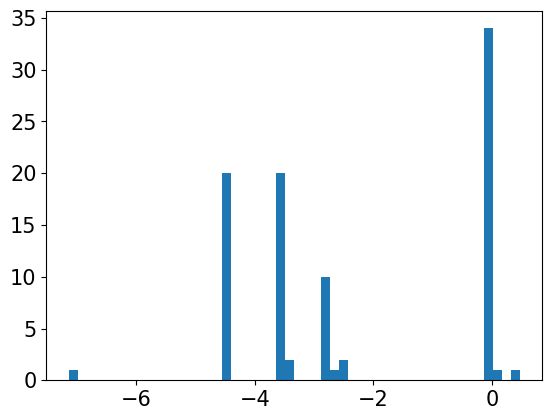

In [4]:
values = []

for i in range(len(pixels)):

    pixid = pixels[i]

    pixel1 = np.argwhere(pixels_ref % (ref_params.n_pixels[0] * ref_params.n_pixels[1]*ref_params.tpc_borders.shape[0]) == pixid)
    # print(pixel1)
    pixel1 = pixel1[0][0]

    xpitch, ypitch, plane, eid = id2pixel(ref_params, pixels[i:i+1])
    xpitch2, ypitch2, plane2, eid2 = id2pixel(ref_params, pixels_ref[pixel1:pixel1+1])
    # print(xpitch, ypitch, plane, eid)
    # print(xpitch2, ypitch2, plane2, eid2)
    assert(xpitch == xpitch2)
    assert(ypitch == ypitch2)
    assert(plane == plane2)
    coords = get_pixel_coordinates(ref_params, xpitch, ypitch, np.zeros(1))
    # if np.abs(coords[0][0] - (-3.3265)) < 1e-5:
    #     print(coords[0][1], adc[i, 0], ref[pixel1, 0])
    diff = np.sum(adc[i, 0]-adc[0, 9]) - np.sum(ref[pixel1, 0]-ref[0, 9])
    if diff < -5:
        print(np.sum(adc[i, :]-adc[0, 9]), np.sum(ref[pixel1, :]-ref[0, 9]), diff, i)
    values.append(diff)
plt.hist(values, bins=50);
    

thresh=1.1214000478806507e-15
thresh=1.1214000478806507e-15
thresh=1.1214000478806507e-15
thresh=1.1214000478806507e-15
thresh=1.1214000478806507e-15
thresh=1.1214000478806507e-15
thresh=1.1214000478806507e-15
thresh=1.1214000478806507e-15
thresh=1.1214000478806507e-15
thresh=1.1214000478806507e-15
24.464111


Text(0.5, 1.0, 'Difference in ADC with both digitizers versions')

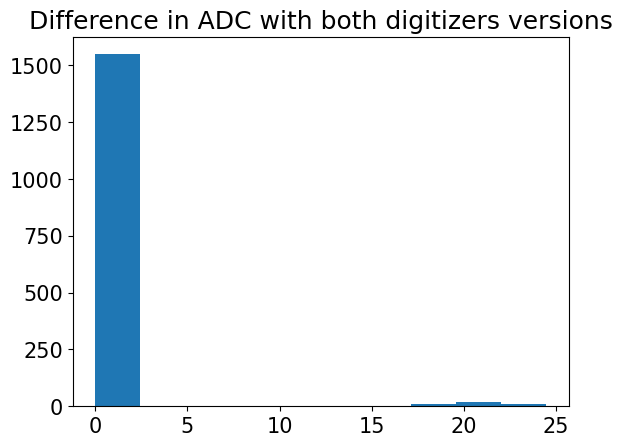

In [33]:
#Checking the digitizers
from larndsim.fee_jax import digitize
from jax import grad, jit, vmap, lax, make_jaxpr, random, debug
from larndsim.fee_jax import digitize

def get_adc_values_ref(pixels_signals,
                time_ticks,
                adc_list,
                adc_ticks_list,
                time_padding=0):

    for ip in range(pixels_signals.shape[0]):
        curre = pixels_signals[ip]
        ic = 0
        iadc = 0
        adc_busy = 0
        true_q = 0
        q_sum = 0

        while ic < curre.shape[0] or adc_busy > 0:

            if iadc >= ref_params.MAX_ADC_VALUES:
                print("More ADC values than possible,", ref_params.MAX_ADC_VALUES)
                break

            q = 0

            if ic < curre.shape[0]:
                q += curre[ic] * ref_params.t_sampling

            q_sum += q
            true_q += q

            q_noise = 0
            disc_noise = 0

            if adc_busy > 0:
                adc_busy -= 1

            if q_sum + q_noise >= ref_params.DISCRIMINATION_THRESHOLD + disc_noise and adc_busy == 0:
                
                interval = round((3 * ref_params.CLOCK_CYCLE + ref_params.ADC_HOLD_DELAY * ref_params.CLOCK_CYCLE) / ref_params.t_sampling)
                integrate_end = ic+interval
                # print(ic, q_sum, integrate_end)

                ic+=1

                while ic <= integrate_end:
                    q = 0

                    if ic < curre.shape[0]:
                        q += curre[ic] * ref_params.t_sampling

                    q_sum += q
                    true_q += q
                    ic+=1

                adc = q_sum 
                disc_noise = 0

                if adc < ref_params.DISCRIMINATION_THRESHOLD + disc_noise:
                    # print("in if statement")
                    ic += round(1 * ref_params.CLOCK_CYCLE / ref_params.t_sampling)
                    q_sum = 0
                    true_q = 0
                    continue

                adc_list[ip][iadc] = adc

                crossing_time_tick = min((ic, len(time_ticks)-1))
                # handle case when tick extends past end of current array
                post_adc_ticks = max((ic - crossing_time_tick, 0))
                #+2-tick delay from when the PACMAN receives the trigger and when it registers it.
                adc_ticks_list[ip][iadc] = time_ticks[crossing_time_tick]+time_padding-2+post_adc_ticks

                # ic += round(RESET_CYCLES * CLOCK_CYCLE / detector.TIME_SAMPLING)
                #TODO: Why is there an additional ic+1 here?
                ic += 1
                # adc_busy = round(ADC_BUSY_DELAY * CLOCK_CYCLE / detector.TIME_SAMPLING)

                q_sum = 0
                true_q = 0

                iadc += 1
                continue

            ic += 1

time_ticks =np.linspace(0, ref_params.time_interval[1], pixel_signals.shape[1]+1)
integral_list = np.zeros((pixel_signals.shape[0], 10))
adc_ticks_list = np.zeros((pixel_signals.shape[0], 10))

get_adc_values_ref(pixel_signals[:]*ref_params.e_charge, time_ticks, integral_list, adc_ticks_list)
# print(integral_list[0])
# print(digitize(ref_params, integral_list[0]))
# print(np.sum(digitize(ref_params, integral_list[0]) - 74.365616))
# print(adc_ticks_list[0])


def get_adc_values(params, pixels_signals):
    """
    Implementation of self-trigger logic

    Args:
        pixels_signals (:obj:`numpy.ndarray`): list of induced currents for
            each pixel
        time_ticks (:obj:`numpy.ndarray`): list of time ticks for each pixel
        adc_list (:obj:`numpy.ndarray`): list of integrated charges for each
            pixel
        adc_ticks_list (:obj:`numpy.ndarray`): list of the time ticks that
            correspond to each integrated charge.
    """

    #Baseline level of noise on integrated charge
    #TODO: Deal better with the rng
    key = random.PRNGKey(42)
    q_sum_base = random.normal(key, (pixels_signals.shape[0],)) * params.RESET_NOISE_CHARGE * params.e_charge

    # Charge
    q = pixels_signals*params.t_sampling

    # Collect cumulative charge over all time ticks + add baseline noise
    q_cumsum = q
    q_sum = q_sum_base[:, jnp.newaxis] + q_cumsum
    # plt.plot(q_sum[pixel0])
    # plt.xlim(1050, 1200)

    def find_hit(carry, it):
        key, q_sum, q_cumsum = carry
        # Index of first threshold passing. For nice time axis differentiability: first find index window around threshold.
        selec_func = lambda x: jnp.where((x[1:] >= params.DISCRIMINATION_THRESHOLD) & 
                    (x[:-1] <= params.DISCRIMINATION_THRESHOLD), size=1, fill_value=q_sum.shape[1]-2)
        idx_t, = vmap(selec_func, 0, 0)(q_sum)
        idx_t = idx_t.ravel()
        # debug.print("idx_t={idx_t}", idx_t=idx_t)
        idx_pix = jnp.arange(0, q_sum.shape[0])
        # Then linearly interpolate for the intersection point.
        # debug.print("q_sum={q_sum}", q_sum=q_sum[idx_pix, idx_t])
        dq = (q_sum[idx_pix, idx_t + 1]-q_sum[idx_pix, idx_t])
        eps = 1e-7
        idx_val = jnp.where(dq < eps*params.DISCRIMINATION_THRESHOLD, 0, idx_t + 1 - (q_sum[idx_pix, idx_t + 1] - params.DISCRIMINATION_THRESHOLD)/dq)
        # debug.print("idx_val={idx_val}", idx_val=idx_val)
        # debug.print("qsum[1142]={q_sum}", q_sum=q_sum[idx_pix, 1142])

        ic = jnp.zeros((q_sum.shape[0],))
        ic = ic.at[idx_pix].set(idx_val)

        # End point of integration
        interval = round((3 * params.CLOCK_CYCLE + params.ADC_HOLD_DELAY * params.CLOCK_CYCLE) / params.t_sampling)
        # integrate_end = ic+interval

        #Protect against ic+integrate_end past last index
        #TODO: This is really weird. How is this thing even differentiable?
        #TODO: Hardfixing to something reasonable, clearly not diff
        integrate_end = idx_t + 1 + interval
        integrate_end = jnp.where(integrate_end >= q_sum.shape[1], q_sum.shape[1]-1, integrate_end)
        end2d_idx = tuple(jnp.stack([jnp.arange(0, ic.shape[0]).astype(int), integrate_end]))
        # integrate_end = jnp.where(integrate_end >= q_sum.shape[1], q_sum.shape[1]-1, integrate_end)
        # end2d_idx = tuple(jnp.stack([jnp.arange(0, ic.shape[0]).astype(int), integrate_end.astype(int)]))

        # Cumulative => value at end is desired value
        q_vals = q_sum[end2d_idx] 
        q_vals_no_noise = q_cumsum[end2d_idx]

        # Uncorrelated noise
        key, = random.split(key, 1)
        extra_noise = random.normal(key, (pixels_signals.shape[0],))  * params.UNCORRELATED_NOISE_CHARGE * params.e_charge

        # Only include noise if nonzero
        # debug.print("end2d_idx={end2d_idx}", end2d_idx=end2d_idx)
        # debug.print("q_vals_no_noise={q_vals_no_noise}", q_vals_no_noise=q_vals_no_noise)
        adc = jnp.where(q_vals_no_noise != 0, q_vals + extra_noise, q_vals_no_noise)
        # debug.print("adc={adc}", adc=adc)
        debug.print("thresh={thresh}", thresh=params.DISCRIMINATION_THRESHOLD)
        cond_adc = adc < params.DISCRIMINATION_THRESHOLD

        # Only include if passes threshold     
        adc = jnp.where(cond_adc, 0, adc)

        # Setup for next loop: baseline noise set to based on adc passing disc. threshold
        key, = random.split(key, 1)
        q_adc_pass = random.normal(key, (pixels_signals.shape[0],)) * params.RESET_NOISE_CHARGE * params.e_charge
        key, = random.split(key, 1)
        q_adc_fail = random.normal(key, (pixels_signals.shape[0],)) * params.UNCORRELATED_NOISE_CHARGE * params.e_charge
        q_sum_base = jnp.where(cond_adc, q_adc_fail, q_adc_pass)

        # Remove charge already counted
        #TODO: Need to add +1 to account for the weird +1 in the original code (feature or bug?)
        integrate_end = idx_t + 1 + interval + 1
        integrate_end = jnp.where(integrate_end >= q_sum.shape[1], q_sum.shape[1]-1, integrate_end)
        end2d_idx = tuple(jnp.stack([jnp.arange(0, ic.shape[0]).astype(int), integrate_end]))
        q_vals_no_noise = q_cumsum[end2d_idx]
        q_cumsum = q_cumsum - q_vals_no_noise[..., jnp.newaxis]
        q_cumsum = jnp.where(q_cumsum < 0, 0, q_cumsum)
        q_sum = q_sum_base[:, jnp.newaxis] + q_cumsum
        

        return (key, q_sum, q_cumsum), (adc, ic)

        # Get ticks
        # adc_ticks_list = (time_ticks.max()-time_ticks.min())/time_ticks.shape[0]*ic + time_padding

        # full_adc.append(adc)
        # full_adc_ticks_list.append(adc_ticks_list)

    # List to contain adc values/ticks
    # full_adc = []
    # full_adc_ticks_list = []

    init_loop = (random.split(key, 1)[0], q_sum, q_cumsum)
    
    _, (full_adc, full_ticks) = lax.scan(find_hit, init_loop, jnp.arange(0, params.MAX_ADC_VALUES))

    #Single iteration to detect NaNs
    # _, (full_adc, full_ticks) = find_hit(init_loop, 0)
    # full_adc = jnp.repeat(full_adc[:, jnp.newaxis], params.MAX_ADC_VALUES, axis=1)
    # full_ticks = jnp.repeat(full_ticks[:, jnp.newaxis], params.MAX_ADC_VALUES, axis=1)
    
    # full_adc_ticks_list = jnp.stack(full_adc_ticks_list, axis=1)

    return full_adc.T, full_ticks.T

# integral, ticks = get_adc_values(ref_params, signals_ref[pixel1:pixel1+1]*ref_params.e_charge)
integral, ticks = get_adc_values(ref_params, pixel_signals[:]*ref_params.e_charge)

# print(integral[0])
# print(digitize(ref_params, integral[0]))
# print(np.sum(digitize(ref_params, integral[0]) - 74.365616))
# print(ticks[0])

print(np.max(np.abs(digitize(ref_params, integral_list) - digitize(ref_params, integral))))
plt.hist((digitize(ref_params, integral_list) - digitize(ref_params, integral)).flatten())
plt.title("Difference in ADC with both digitizers versions")

In [93]:
print(ref_params)

Params(eField=0.5, Ab=0.8, kb=0.0486, lifetime=1000000.0, vdrift=0.1596452482154287, long_diff=0, tran_diff=0, tpc_borders=Array([[[-31.039  ,  31.039  ],
        [-83.8626 ,  40.2154 ],
        [-30.431  ,  -0.15875]],

       [[-31.039  ,  31.039  ],
        [-83.8626 ,  40.2154 ],
        [ 30.431  ,   0.15875]]], dtype=float32), box=1, birks=2, lArDensity=1.38, alpha=0.93, beta=0.207, MeVToElectrons=42370.0, pixel_pitch=0.4434, n_pixels=(140, 280), max_radius=0, max_active_pixels=0, drift_length=30.27225, t_sampling=0.1, time_interval=array([  0., 200.]), time_padding=190, min_step_size=0.001, time_max=0, time_window=189.1, e_charge=1.602e-19, temperature=87.17, response_bin_size=0.04434, number_pix_neighbors=5, electron_sampling_resolution=0.001, signal_length=200, MAX_ADC_VALUES=10, DISCRIMINATION_THRESHOLD=1.1214e-15, ADC_HOLD_DELAY=15, CLOCK_CYCLE=0.1, GAIN=0.004, V_CM=288, V_REF=1300, V_PEDESTAL=580, ADC_COUNTS=256, RESET_NOISE_CHARGE=0, UNCORRELATED_NOISE_CHARGE=0)


Adc in jax -> 74.365616
Ticks in ref -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
Adc in ref -> 74.0
Ticks in jax -> [991. 991. 991. 991. 991. 991. 991. 991. 991. 991.]
Adc in jax -> 74.365616


Text(0.5, 0, 'Time ticks')

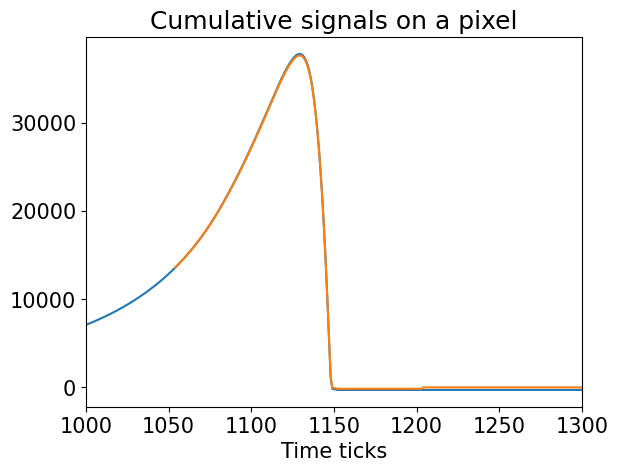

In [36]:
from larndsim.fee_jax import get_adc_values, digitize
integral, ticks = get_adc_values(ref_params, signals_ref[pixel1:pixel1+1, :]*ref_params.e_charge)
print(integral)
print("Interval ->", round((3 * ref_params.CLOCK_CYCLE + ref_params.ADC_HOLD_DELAY * ref_params.CLOCK_CYCLE) / ref_params.t_sampling))
# print(digitize(ref_params, integral))
plt.plot(signals_ref[pixel1, :])
plt.xlim(200, 350)

plt.axvline(ticks[0][0], color='red')
plt.axvline(ticks[0][0] + 18, color='red', linestyle='dashed')
plt.axvline(ticks[0][1], color='red')
plt.plot(signals_ref[pixel1, :].cumsum())

NameError: name 'pixel1' is not defined

In [60]:
(3 * ref_params.CLOCK_CYCLE + ref_params.ADC_HOLD_DELAY * ref_params.CLOCK_CYCLE) / ref_params.t_sampling

18.0

In [59]:
print(ref_params.t_sampling)

0.1


In [27]:
pixels_ref % (ref_params.n_pixels[0] * ref_params.n_pixels[1]*ref_params.tpc_borders.shape[0])

Array([78399, 78399, 78399, 78399, 78399, 78399, 78399, 27917, 27918,
       27919, 28057, 28058, 28059, 28060, 28197, 28198, 28199, 28200,
       28337, 28338, 28339, 28340, 28478, 28479, 28480, 28481, 28618,
       28619, 28620, 28621, 28758, 28759, 28760, 28761, 28899, 28900,
       28901, 28902, 29039, 29040, 29041, 29042, 29179, 29180, 29181,
       29182, 29320, 29321, 29322, 29323, 29460, 29461, 29462, 29463,
       29600, 29601, 29602, 29603, 29741, 29742, 29743, 29744, 29881,
       29882, 29883, 29884, 30021, 30022, 30023, 30024, 30162, 30163,
       30164, 30165, 30302, 30303, 30304, 30305, 30442, 30443, 30444,
       30445, 30583, 30584, 30585, 30586, 30723, 30724, 30725, 30726,
       30863, 30864, 30865, 30866, 31004, 31005, 31006, 31007, 31144,
       31145, 31146, 31147, 31284, 31285, 31286, 31287, 31425, 31426,
       31427, 31428, 31565, 31566, 31567, 31568, 31705, 31706, 31707,
       31708, 31846, 31847, 31848, 31849, 31986, 31987, 31988, 31989,
       32126, 32127,

(92, 2001)


(0.0, 60.0)

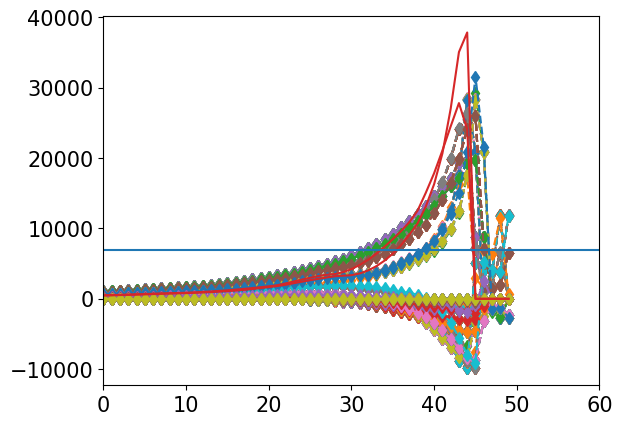

In [5]:
print(pixel_signals.shape)
# plt.plot(signals[0,0, 1124:1154].T, 'o-');
# plt.plot(pixel_signals[:, -60:].T, 'o-');
# plt.plot(pixel_signals[:, 1105:].T, 'o-', color='tab:blue');
# plt.xlim(1100, 1200)

# print(signals_ref.shape)
plt.plot(signals_ref[:, 50:100].T, 'd--');

# plt.plot(response[2, 2, -30:]*64306.098)
plt.plot(response[2, 2, -50:]*21616.999875*3*0.4, color='tab:red')
plt.plot(response[3, 2, -50:]*21616.999875*3*0.4, color='tab:red')
plt.axhline(7000)
plt.xlim(0, 60)

In [69]:
with_adc = adc[:, 0] != adc[0, 9]
pixels_filtered = pixels[with_adc]
with_adc = ref[:, 0] != ref[0, 9]
pixels_ref_filtered = pixels_ref[with_adc] - 3*ref_params.tpc_borders.shape[0]*ref_params.n_pixels[0]*ref_params.n_pixels[1]
# print(id2pixel(ref_params, pixels))
# print(id2pixel(ref_params, pixels_ref[pixels_ref != -1]))
pixels_filtered = set(pixels_filtered.tolist())
pixels_ref_filtered = set(pixels_ref_filtered.tolist())
print("N orig -> ", len(pixels_filtered))
print("N jax -> ", len(pixels_ref_filtered))
print("N intersect -> ", len(pixels_filtered.intersection(pixels_ref_filtered)))

N orig ->  58
N jax ->  89
N intersect ->  57


(92, 2001)
(289, 1892)


IndexError: boolean index did not match shape of indexed array in index 0: got (92,), expected (289,)

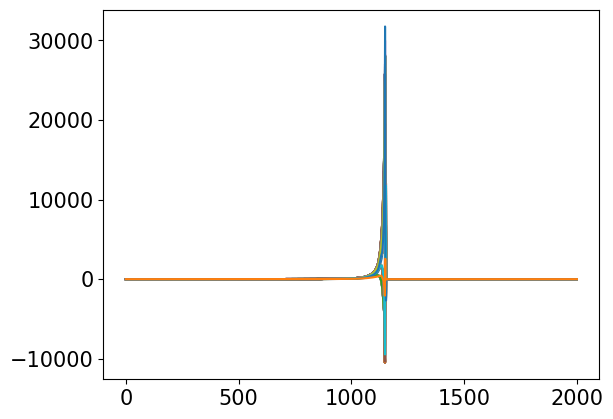

In [11]:
#Comparing the signals for ref and jax
plt.figure()
print(pixel_signals.shape)
plt.plot(pixel_signals[:, :].T);
# plt.xlim(1100, 1200)

plt.figure()
print(signals_ref.shape)
with_adc = ref[:, 0] != ref[0, 0]
lines = plt.plot(signals_ref[~with_adc].T);
plt.xlim(150, 250)
len(lines)

In [26]:
#Building a basic example

def get_length(track):
    return np.sqrt(
        (track['x_start'] - track['x_end'])**2 + 
        (track['y_start'] - track['y_end'])**2 + 
        (track['z_start'] - track['z_end'])**2
    ) 

def point_like(tracks, x=-12, y=20, z=5):
    track = tracks[:1].copy()

    #Drift direction
    track[0]['x_start'] = x
    track[0]['x_end'] = x
    track[0]['x'] = x

    track[0]['z_start'] = z - 0.000001
    track[0]['z_end'] = z + 0.000001
    track[0]['z'] = z

    track[0]['y_start'] = y - 0.000001
    track[0]['y_end'] = y + 0.000001
    track[0]['y'] = y

    track[0]['dx'] = get_length(track[0])
    track[0]['dEdx'] = 0.8/track[0]['dx']
    track[0]['dE'] = track[0]['dx']*track[0]['dEdx']

    return track


with h5py.File("./single_track.h5", 'r') as f:
    tracks = np.array(f['segments'])

single_edep = point_like(tracks)
single_edep2 = point_like(tracks, -12, 20, 4.5)

double_edep = np.stack([single_edep[0], single_edep2[0]])

with h5py.File("./single_edep.h5", 'w') as f:
    f.create_dataset('segments', data=single_edep)

with h5py.File("./double_edep.h5", 'w') as f:
    f.create_dataset('segments', data=double_edep)

import pandas as pd
from IPython.display import display, HTML

selected_fields = ['x', 'x_start', 'x_end', 'y', 'y_start', 'y_end', 'z', 'z_start', 'z_end', 'dE', 'dx', 'dEdx', 't_start']

with h5py.File("./single_edep.h5", 'r') as f:
    display(pd.DataFrame(np.array(f['segments']))[selected_fields])

,x,x_start,x_end,y,y_start,y_end,z,z_start,z_end,dE,dx,dEdx,t_start
0,-12.0,-12.0,-12.0,20.0,19.999998,20.000002,5.0,4.999999,5.000001,0.8,0.000004,187574.96875,0.0


In [37]:
import h5py
import numpy as np

#Building a basic example

def get_length(track):
    return np.sqrt(
        (track['x_start'] - track['x_end'])**2 + 
        (track['y_start'] - track['y_end'])**2 + 
        (track['z_start'] - track['z_end'])**2
    ) 

def single_track(tracks):
    track = tracks[:1].copy()

    #Drift direction
    track[0]['x_start'] = -20
    track[0]['x_end'] = -1
    track[0]['x'] = -10.5

    track[0]['z_start'] = -5
    track[0]['z_end'] = 5
    track[0]['z'] = 0

    track[0]['y_start'] = 5
    track[0]['y_end'] = 35
    track[0]['y'] = 20

    track[0]['dx'] = get_length(track[0])
    track[0]['dEdx'] = 2
    track[0]['dE'] = track[0]['dx']*track[0]['dEdx']

    return track

def single_track_nodz(tracks):
    track = tracks[:1].copy()

    #Drift direction
    track[0]['x_start'] = 12
    track[0]['x_end'] = 12
    track[0]['x'] = 12

    track[0]['z_start'] = -5
    track[0]['z_end'] = 5
    track[0]['z'] = 0

    track[0]['y_start'] = 5
    track[0]['y_end'] = 35
    track[0]['y'] = 20

    track[0]['dx'] = get_length(track[0])
    track[0]['dEdx'] = 2
    track[0]['dE'] = track[0]['dx']*track[0]['dEdx']

    return track

def double_track(tracks):
    track = tracks[:1].copy()
    track = np.stack([track[0], track[0]])

    #Drift direction
    track[0]['x_start'] = 12.01
    track[0]['x_end'] = 12
    track[0]['x'] = 12.005

    track[0]['z_start'] = -5
    track[0]['z_end'] = 0
    track[0]['z'] = -2.5

    track[0]['y_start'] = 5
    track[0]['y_end'] = 20
    track[0]['y'] = 12.5

    track[0]['dx'] = get_length(track[0])
    track[0]['dEdx'] = 2
    track[0]['dE'] = track[0]['dx']*track[0]['dEdx']
    track[0]['trackID'] = 0

    #Drift direction
    track[1]['x_start'] = 12
    track[1]['x_end'] = 11.99
    track[1]['x'] = 11.995

    track[1]['z_start'] = 0
    track[1]['z_end'] = 5
    track[1]['z'] = 2.5

    track[1]['y_start'] = 20
    track[1]['y_end'] = 35
    track[1]['y'] = 27.5

    track[1]['dx'] = get_length(track[1])
    track[1]['dEdx'] = 2
    track[1]['dE'] = track[1]['dx']*track[1]['dEdx']
    track[1]['trackID'] = 1

    return track

with h5py.File("./single_track.h5", 'r') as f:
    tracks = np.array(f['segments'])

track_single = single_track(tracks)

with h5py.File("./single_track_drift.h5", 'w') as f:
    f.create_dataset('segments', data=track_single)

track_single_nodz = single_track_nodz(tracks)

with h5py.File("./simplified_single_track_nodz.h5", 'w') as f:
    f.create_dataset('segments', data=track_single_nodz)

track_double = double_track(tracks)

with h5py.File("./simplified_single_track_split.h5", 'w') as f:
    f.create_dataset('segments', data=track_double)

print(track_double)

import pandas as pd
from IPython.display import display, HTML

print(track_double.dtype.names)

selected_fields = ['x', 'x_start', 'x_end', 'y', 'y_start', 'y_end', 'z', 'z_start', 'z_end', 'dE', 'dx', 'dEdx']

with h5py.File("./simplified_single_track_split.h5", 'r') as f:
    display(pd.DataFrame(np.array(f['segments']))[selected_fields])

[(3, 0., 0, 0., -5., 12.  , 20., 0, 13, 12.01,  5., 0., 0.00084798, 0.00123894, 0.00104346, 15.811392, 0., 0, 0., 2., 31.622784, 0., 12.5, 12.005, -2.5, 0.)
 (3, 5., 1, 0.,  0., 11.99, 35., 0, 13, 12.  , 20., 0., 0.00084798, 0.00123894, 0.00104346, 15.811392, 0., 0, 0., 2., 31.622784, 0., 27.5, 11.995,  2.5, 0.)]
('eventID', 'z_end', 'trackID', 'tran_diff', 'z_start', 'x_end', 'y_end', 'n_electrons', 'pdgId', 'x_start', 'y_start', 't_start', 't0_start', 't0_end', 't0', 'dx', 'long_diff', 'pixel_plane', 't_end', 'dEdx', 'dE', 't', 'y', 'x', 'z', 'n_photons')


,x,x_start,x_end,y,y_start,y_end,z,z_start,z_end,dE,dx,dEdx
0,12.005,12.01,12.00,12.5,5.0,20.0,-2.5,-5.0,0.0,31.622784,15.811392,2.0
1,11.995,12.00,11.99,27.5,20.0,35.0,2.5,0.0,5.0,31.622784,15.811392,2.0


# Fitting

In [ ]:
#Running some fit

# to_propagate = ("Ab", "kb", "lifetime")
to_propagate = ("Ab",)
history = []

niter = 1

modified_params = {
    'Ab': 0.805,
    # 'kb': 0.0786,
    # "lifetime": 5e3,
    # "tran_diff": ref_params.tran_diff*1.1,
    # "long_diff": ref_params.long_diff*0.9
    # "tran_diff": 6e-6
}

lr = {
    'Ab': 1e-2,
    # 'lifetime': 1e-2,
    # 'kb': 1e-2
}

def extract_relevant_params(params, relevant):
    return {par: getattr(params, par) for par in relevant}

def update_params(params, update):
    return params.replace(**{key: getattr(params, key) + val for key, val in update.items()})

noisy_ref = ref# + jax.random.normal(jax.random.PRNGKey(87), ref.shape)*0.1

params = ref_params.replace(**modified_params)

params_normalization = params.replace()

norm_params = params.replace(**{key: 1. for key in to_propagate})

optimizer = optax.multi_transform({key: optax.adam(value) for key, value in lr.items()},
                                  {key: key for key in to_propagate})

opt_state = optimizer.init(extract_relevant_params(norm_params, to_propagate))


# with jax.profiler.trace("/tmp/tensorboard"):
losses = []
gradd_list = []
for i in tqdm(range(niter)):
    history.append(params)

    (loss_val, aux), grads = value_and_grad(params_loss, (0), has_aux=True)(params, noisy_ref, pixels_ref, ticks_ref, tracks, fields)

    updates, opt_state = optimizer.update(extract_relevant_params(grads, to_propagate), opt_state)
    norm_params = update_params(norm_params, updates)
    # norm_params = optax.apply_updates(norm_params, updates)
    params = norm_params.replace(**{key: getattr(norm_params, key)*getattr(params_normalization, key) for key in to_propagate})
    losses.append(loss_val)
    gradd_list.append(grads)
flat_history = {}
for key in to_propagate:
    flat_history[key] = [getattr(par, key) for par in history]

100%|██████████| 1/1 [00:04<00:00,  4.71s/it]


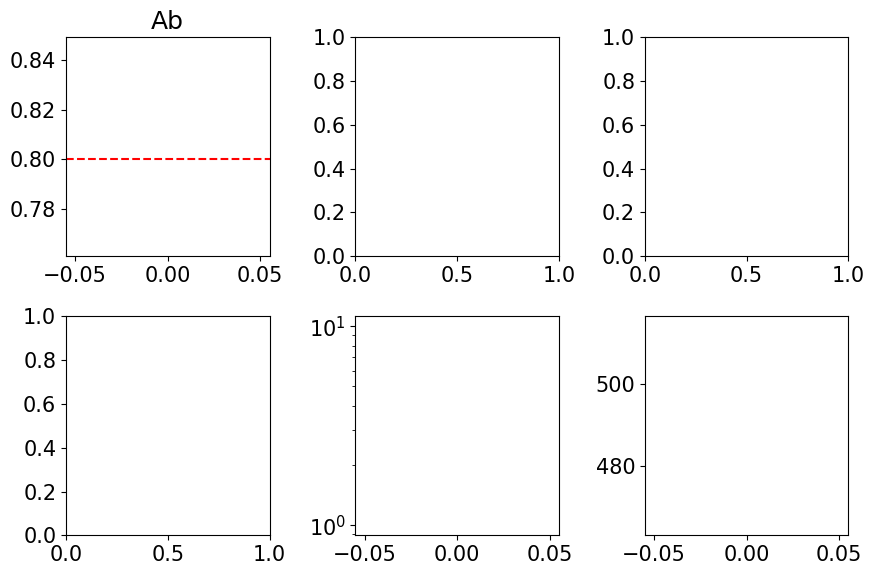

In [ ]:
#Plotting of the fits
nrows, ncols = 2, 3
fig, axs = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))

for it, key in enumerate(to_propagate):
    i = it//ncols
    j = it%ncols

    ax = axs[i, j]
    ax.plot(flat_history[key])
    ax.axhline(getattr(ref_params, key), linestyle='dashed', color='red')
    ax.set_title(key)

axs[1, 1].plot(losses)
axs[1, 2].plot([getattr(g, 'Ab') for g in gradd_list])
axs[1, 1].set_yscale('log')
fig.tight_layout()

# Garbage part

flat_indices (135000000,)
start_indices (300000, 9)
end_indices (300000, 9, 50)
signal_indices (135000000,)
(100, 1891)


(0.0, 300.0)

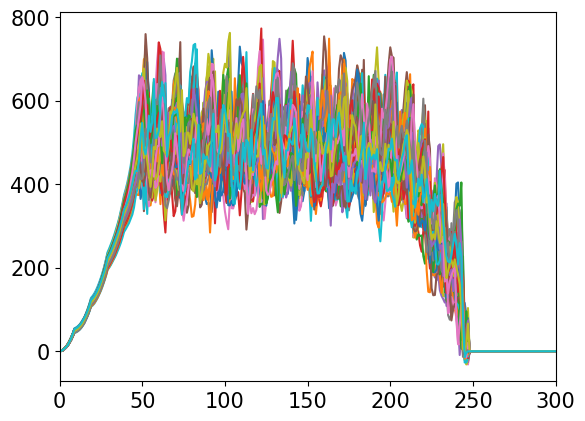

In [ ]:
import jax
from functools import partial

@partial(jit, static_argnames='signal_length')
def toy(wfs, currents_idx, charge, response, pixID, start_ticks, signal_length):
    # Get the number of pixels and ticks
    Npixels, Nticks = wfs.shape

    # Compute indices for updating wfs, taking into account start_ticks
    start_indices = pixID * Nticks + start_ticks[:, jnp.newaxis]

    end_indices = start_indices[..., None] + jnp.arange(signal_length)

    # Flatten the indices
    flat_indices = jnp.ravel(end_indices)
    print("flat_indices", flat_indices.shape)
    print("start_indices", start_indices.shape)
    print("end_indices", end_indices.shape)

    Nx, Ny, Nt = response.shape

    signal_indices = jnp.ravel((currents_idx[..., 0, None]*Ny + currents_idx[..., 1, None])*Nt + jnp.arange(response.shape[-1] - signal_length, response.shape[-1]))
    print("signal_indices", signal_indices.shape)

    Np = pixID.shape[-1]

    # Update wfs with accumulated signals
    wfs = wfs.ravel()
    wfs = wfs.at[(flat_indices,)].add(response.take(signal_indices)*jnp.repeat(charge, Np*signal_length))
    return wfs.reshape((Npixels, Nticks))

npixels = 100
nelec = 300000
nneigh = 9
signal_length = 50

key = random.PRNGKey(0)
currents_idx = jax.random.randint(key, (nelec, nneigh, 2), 0, 15)
pix_renumbering = jax.random.randint(key, (nelec, nneigh), 0, npixels)
start_ticks = jax.random.randint(key, (nelec,), 0, 200)
earliest_tick = jnp.min(start_ticks)
electrons = jax.random.randint(key, (nelec,), 0, 10)

response = np.load("/home/pgranger/larnd-sim/jit_version/original/build/lib/larndsim/bin/response_44.npy")
wfs = jnp.zeros((npixels, response.shape[-1]))
wfs = toy(wfs, currents_idx, electrons, response, pix_renumbering, start_ticks - earliest_tick, signal_length)
# jnp.repeat(electrons, nneigh*signal_length)

print(wfs.shape)
plt.plot(wfs[:, :].T);
plt.xlim(0, 300)

(0.001, 1.2)

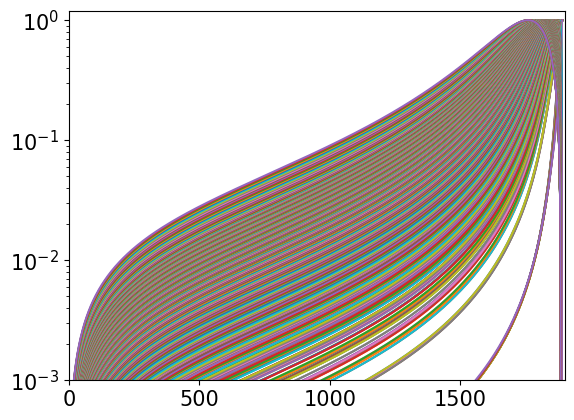

In [38]:
response = np.load("/home/pgranger/larnd-sim/jit_version/original/build/lib/larndsim/bin/response_44.npy")
data = np.cumsum(response.reshape(response.shape[0]*response.shape[1], response.shape[-1]).T, axis=0)
lines = plt.plot(data/np.max(data, axis=0));
plt.xlim(0, 1900)
plt.yscale('log')
plt.ylim(1e-3, 1.2)
# print(len(lines))

(0.001, 100)

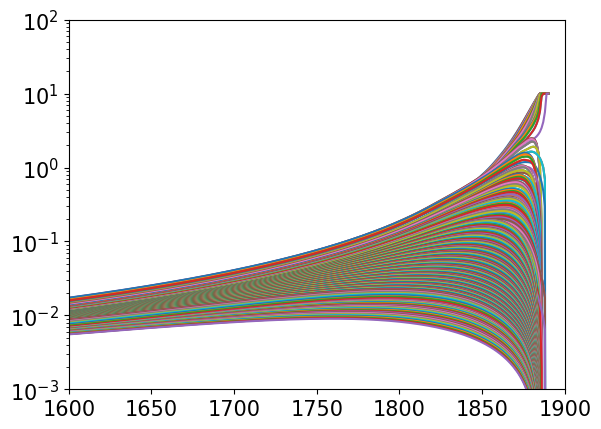

In [33]:
response = np.load("/home/pgranger/larnd-sim/jit_version/original/build/lib/larndsim/bin/response_44.npy")
data = np.cumsum(response.reshape(response.shape[0]*response.shape[1], response.shape[-1]).T, axis=0)
# lines = plt.plot(response.reshape(response.shape[0]*response.shape[1], response.shape[-1]).T);
lines = plt.plot(data);
plt.xlim(1600, 1900)
plt.yscale('log')
plt.ylim(1e-3, 100)
# print(len(lines))

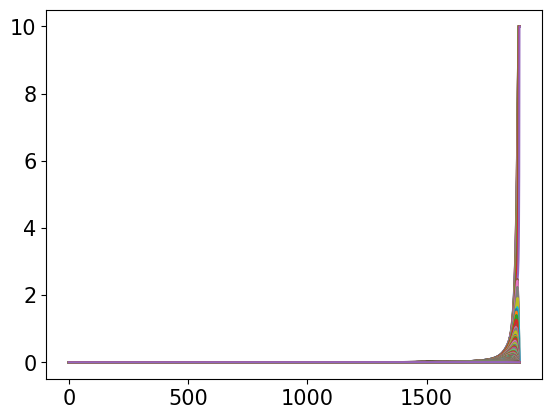

In [5]:
response = np.load("/home/pgranger/larnd-sim/jit_version/original/build/lib/larndsim/bin/response_44.npy")
signal_length = 100
data = np.cumsum(response, axis=-1)
# data = data[:, :, -signal_length:]
np.save("/home/pgranger/larnd-sim/jit_version/original/build/lib/larndsim/bin/response_integrated_100.npy", data)
plt.plot(data.reshape(data.shape[0]*data.shape[1], data.shape[-1]).T);

(2025, 1891)

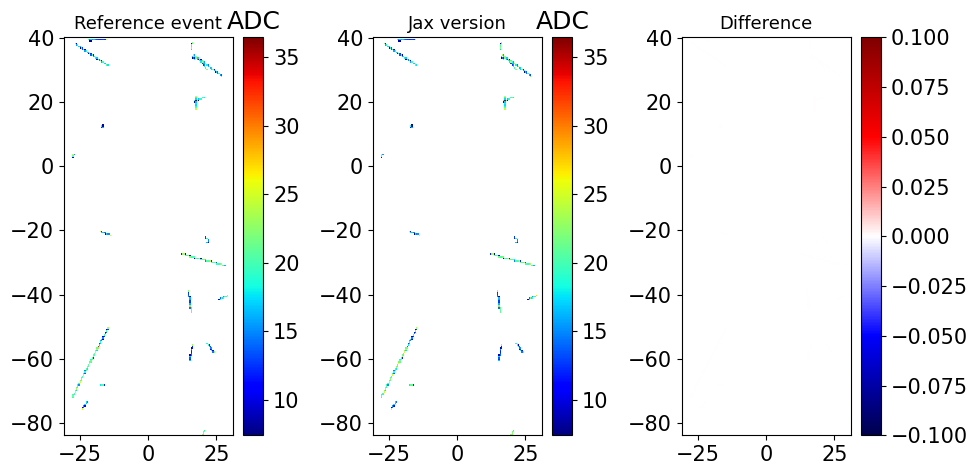

<Figure size 640x480 with 0 Axes>

In [7]:
def load_results(fname):
    # fname = "/home/pgranger/larnd-sim/tools/evd/data/result_legacy_nonoise.h5"
    with h5py.File(fname, 'r') as f:
        pixels = np.array(f['pixels'])
        adc = np.array(f['adc'])
        # signals = np.array(f['signals'])
        signals = None
        pixel_signals = np.array(f['pixel_signals'])
        ticks = np.array(f['ticks'])
    return pixels, signals, adc, ticks, pixel_signals

Params = build_params_class([])
ref_params = load_detector_properties(Params, "/home/pgranger/larnd-sim/jit_version/larnd-sim/larndsim/detector_properties/module0.yaml",
                                "/home/pgranger/larnd-sim/jit_version/larnd-sim/larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml")
ref_params = ref_params.replace(kb=0, tran_diff=0, long_diff=0)

# pixels, signals, adc, ticks, pixel_signals = load_results("/home/pgranger/larnd-sim/jit_version/original/simplified_single_track_split_output_lifetime.h5")
# pixels_ref, _, ref, _, _ = load_results("/home/pgranger/larnd-sim/jit_version/original/simplified_single_track_output_lifetime.h5")
pixels_ref, _, ref, _, _ = load_results("/home/pgranger/larnd-sim/jit_version/larnd-sim/jax_output/output_jax-sampling_0.001-neighbor_1-length_150-7.h5")
pixels, _, adc, _, _ = load_results("/home/pgranger/larnd-sim/jit_version/larnd-sim/jax_output/output_jax-sampling_0.001-neighbor_1-length_150-7.h5")
# pixels, signals, adc, ticks, pixel_signals = load_results("/home/pgranger/larnd-sim/jit_version/original/single_edep_output_lifetime.h5")
# pixels, signals, adc, ticks, pixel_signals = load_results("/home/pgranger/larnd-sim/jit_version/original/double_edep_output_lifetime.h5")
# pixels, signals, adc, ticks = load_results("/home/pgranger/larnd-sim/jit_version/original/single_track_output_lifetime.h5")

fig, axs = plt.subplots(1, 3, figsize=(10, 5))

xpitch, ypitch, plane, eid = id2pixel(ref_params, pixels)
coords = get_pixel_coordinates(ref_params, xpitch, ypitch, np.zeros(pixels.shape[0]))
xbins = np.linspace(ref_params.tpc_borders[0][0][0], ref_params.tpc_borders[0][0][1], ref_params.n_pixels[0] + 1)
ybins = np.linspace(ref_params.tpc_borders[0][1][0], ref_params.tpc_borders[0][1][1], ref_params.n_pixels[1] + 1)
# xbins = np.linspace(-10, 10, int(np.ceil(20./ref_params.pixel_pitch)))
# ybins = np.linspace(0, 40, int(np.ceil(40./ref_params.pixel_pitch)))
h1, _, _, im = axs[0].hist2d(coords[:, 0], coords[:, 1], bins=(xbins, ybins), cmap='jet', weights=adc[:, 0]-adc[0, 9], cmin=1e-5);
cbar = fig.colorbar(im, ax=axs[0])
cbar.ax.set_title("ADC")
plt.figure()
xpitch, ypitch, plane, eid = id2pixel(ref_params, pixels_ref)
coords = get_pixel_coordinates(ref_params, xpitch, ypitch, np.zeros(pixels_ref.shape[0]))
h2, _, _, im = axs[1].hist2d(coords[:, 0], coords[:, 1], bins=(xbins, ybins), cmap='jet', weights=ref[:, 0]-ref[0, 9], cmin=1e-5);
cbar = fig.colorbar(im, ax=axs[1])
cbar.ax.set_title("ADC")
axs[0].set_title("Reference event", fontsize=13)
axs[1].set_title("Jax version", fontsize=13)
# fig.tight_layout()
# fig.savefig("evd_diff.pdf")
# coords = get_pixel_coordinates(ref_params, pixels[:, 0], pixels[:, 1], np.zeros(adcs.shape[0]))

im = axs[2].pcolormesh(xbins, ybins, h1.T - h2.T, cmap='seismic')
cbar = fig.colorbar(im, ax=axs[2])
axs[2].set_title("Difference", fontsize=13)
# plt.colorbar()
fig.tight_layout()